In [167]:
import matplotlib
from matplotlib import pylab
%config InlineBackend.figure_format = 'retina'
matplotlib.rcParams['figure.dpi'] = 80
params = {'legend.fontsize': 'xx-large',
          'figure.figsize': (6, 4),
         'axes.labelsize': 'xx-large',
         'axes.titlesize': 'xx-large',
         'xtick.labelsize': 'x-large',
         'ytick.labelsize': 'x-large',
         'figure.facecolor': 'w'}
pylab.rcParams.update(params)
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec

import h5py
import numpy as np
import os
import sys
import torch
import yaml
from scipy.optimize import curve_fit

%load_ext autoreload
%autoreload 2
sys.path.insert(1, '../code')
from geometric_features import GeometricFeaturizer, geo_name
from scalar_features import ScalarFeaturizer, scalar_name
from read_halos import SimulationReader
from fit import LinearFitter
from neural_net import NeuralNet, NNFitter
import plotter
import utils
import feature_importance

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [168]:
sim_name = 'TNG100-1'
#sim_name = 'TNG50-4'
sim_name_dark = f'{sim_name}-Dark'

halo_tag = ''
geo_tag = ''
scalar_tag = ''
mass_multiplier = 1e10
log_mass_shift = 10

## Load features

In [169]:
fn_halo_config = f'../configs/halos_{sim_name}{halo_tag}.yaml'
print(fn_halo_config)
fn_geo_config = f'../configs/geo_{sim_name}{halo_tag}{geo_tag}.yaml'
print(fn_geo_config)
fn_scalar_config = f'../configs/scalar_{sim_name}{halo_tag}{geo_tag}{scalar_tag}.yaml'
print(fn_scalar_config)

../configs/halos_TNG100-1.yaml
../configs/geo_TNG100-1.yaml
../configs/scalar_TNG100-1.yaml


In [170]:
with open(fn_scalar_config, 'r') as file:
    scalar_params = yaml.safe_load(file)
scp = scalar_params['scalar']

fn_geo_config = scalar_params['geo']['fn_geo_config']
with open(fn_geo_config, 'r') as file:
    geo_params = yaml.safe_load(file)
gp = geo_params['geo']

with open(fn_halo_config, 'r') as file:
    halo_params = yaml.safe_load(file)

fn_dark_halo_arr = halo_params['halo']['fn_dark_halo_arr']

In [171]:
geo_featurizer = GeometricFeaturizer()
geo_featurizer.load_features(gp['fn_geo_features'])

In [172]:
sim_reader = SimulationReader(halo_params['sim']['base_dir'], sim_name, sim_name_dark, 
                              halo_params['sim']['snap_num_str'])
sim_reader.load_dark_halo_arr(fn_dark_halo_arr)
sim_reader.read_simulations()

In [173]:
mrv_for_rescaling = utils.get_mrv_for_rescaling(sim_reader, scp['mrv_names_for_rescaling'])
scalar_featurizer = ScalarFeaturizer(geo_featurizer.geo_feature_arr,
                        n_groups_rebin=scp['n_groups_rebin'], 
                        transform_pseudotensors=scp['transform_pseudotensors'], 
                        mrv_for_rescaling=mrv_for_rescaling)

Rebinning geometric features
Transforming pseudotensors
Rescaling geometric features


In [174]:
x_features_extra = np.log10(mrv_for_rescaling).T

In [175]:
print('loading')
scalar_featurizer.load_features(scp['fn_scalar_features'])
print('loaded')

loading
loaded


## Other features

In [211]:
x_dict = {}
x_extra_dict = {}

In [214]:
x_dict['scalars'] = scalar_featurizer.scalar_features
x_extra_dict['scalars'] = x_features_extra

x_dict['geos'] = utils.geo_feature_arr_to_values(scalar_featurizer.geo_feature_arr)
x_extra_dict['geos'] = x_features_extra

x_dict['mrv'] = x_features_extra
x_extra_dict['mrv'] = None

catalog_feature_names = ['M200c', 'c200c', 'a_form']
sim_reader.get_structure_catalog_features(catalog_feature_names)
x_dict['catalog'] = sim_reader.x_catalog_features
x_extra_dict['catalog'] = None

## Gather properties

In [176]:
sim_reader.add_catalog_property_to_halos('m200m')
m_200m = np.array([dark_halo.catalog_properties['m200m'] for dark_halo in sim_reader.dark_halo_arr])
log_m_200m = np.log10(m_200m)

## Split train-val-test

In [177]:
frac_train = 0.70
frac_val = 0.15
frac_test = 0.15

random_ints = np.array([dark_halo.random_int for dark_halo in sim_reader.dark_halo_arr])
idx_train, idx_val, idx_test = utils.split_train_val_test(random_ints, frac_train=frac_train, 
                                                      frac_val=frac_val, frac_test=frac_test)

In [178]:
x_test = scalar_featurizer.scalar_features[idx_test]
y_test_current = None
x_test_extra = x_features_extra[idx_test]

## Mstellar

In [13]:
y_label_name = 'm_stellar'

In [19]:
#fit_tag = f'_{y_label_name}_nn'
#fit_tag = f'_{y_label_name}_nn_epochs500_lr0.0001_hs64'
fit_tag = f'_{y_label_name}_nn_scalars_epochs1000_lr5e-05_hs128'
#fit_tag = f'_{y_label_name}_nn_scalars_epochs1000_lr1e-05_hs128'

fn_model = f'../models/models_{sim_name}/model_{sim_name}{halo_tag}{geo_tag}{scalar_tag}{fit_tag}.pt'

In [20]:
y = utils.get_y_vals(y_label_name, sim_reader)
y_test = y[idx_test]

In [21]:
nnfitter = NNFitter()
nnfitter.load_model(fn_model)

In [22]:
import torch
model_checkpoint = torch.load(fn_model)

In [23]:
#model_checkpoint

669 0.3035498327965382


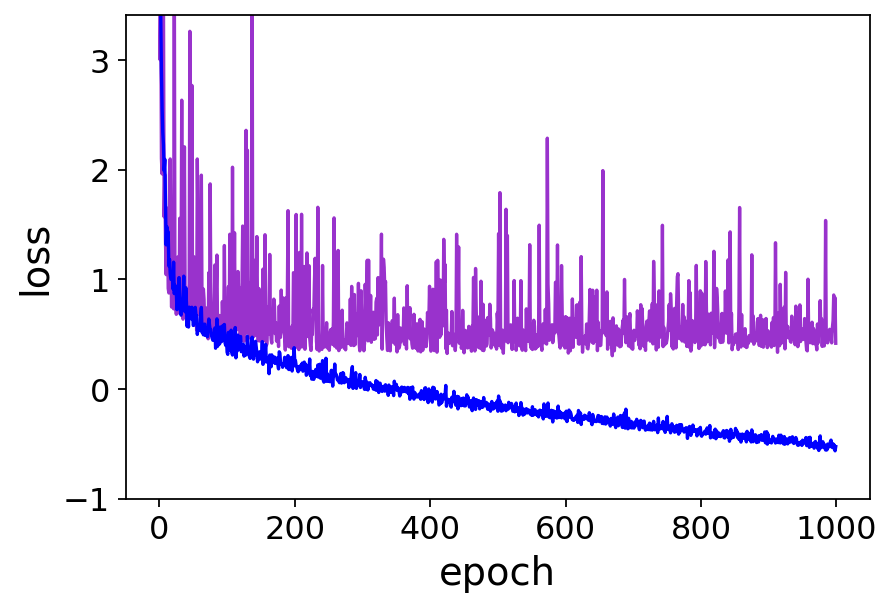

In [25]:
plt.plot(nnfitter.loss_valid, color='darkorchid', label='Validation')
plt.plot(nnfitter.loss_train, color='blue', label='Training')
plt.xlabel('epoch')
plt.ylabel('loss')
#plt.ylim(0,300)
plt.ylim(-1, nnfitter.loss_train[2])
print(np.argmin(nnfitter.loss_valid), np.min(nnfitter.loss_valid))

In [27]:
# plt.plot(nnfitter.loss, color='darkorchid')
# plt.xlabel('epoch')
# plt.ylabel('loss')

In [28]:
y_pred = nnfitter.predict(x_test, y_current=y_test_current, x_extra=x_test_extra)

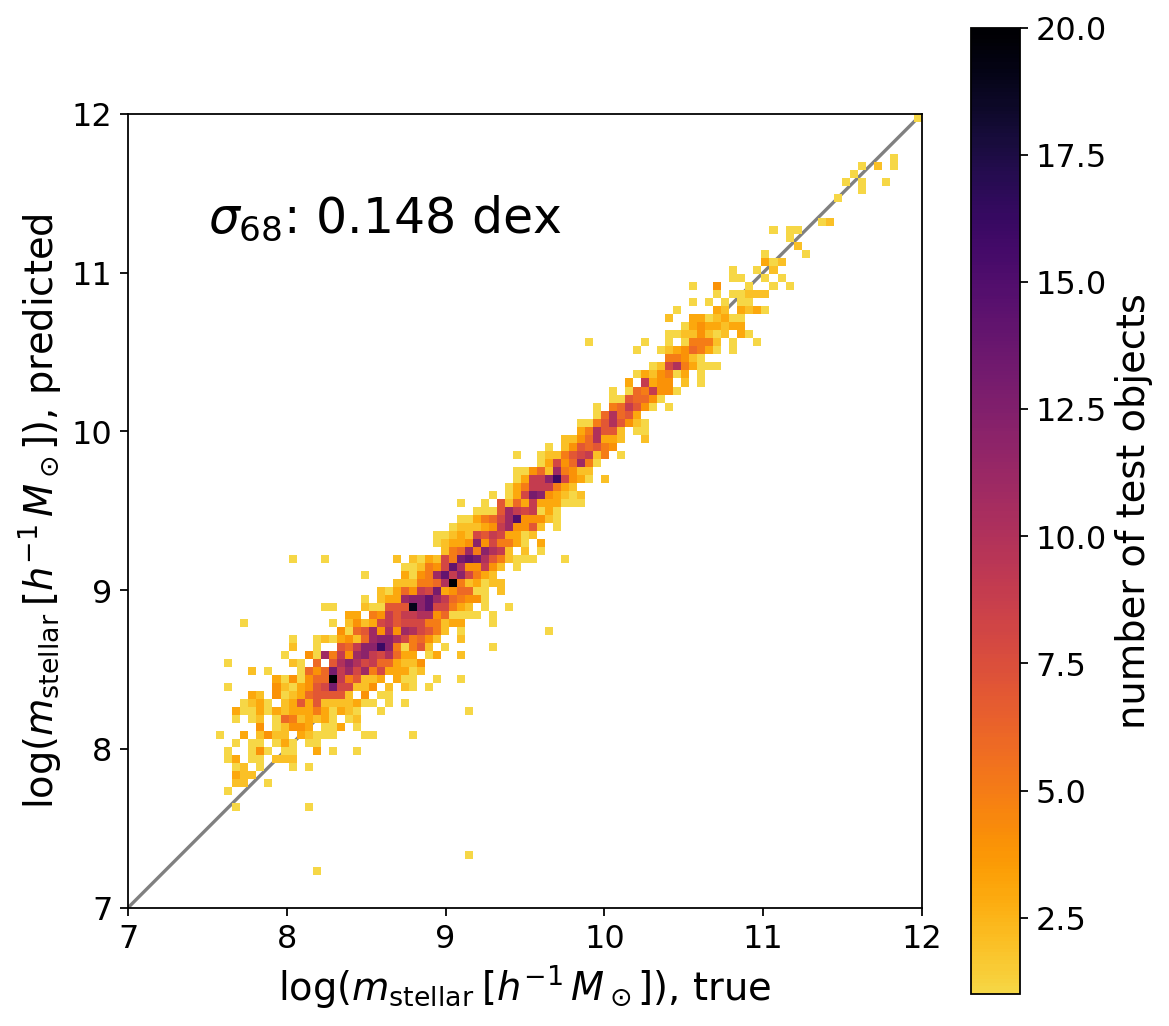

In [29]:
y_test_mult = y_test + log_mass_shift
y_pred_mult = y_pred + log_mass_shift
error_nn, _ = utils.compute_error(y_test_mult, y_pred_mult, test_error_type='percentile')
error_str = fr"$\sigma_{{68}}$: {error_nn:.3f} dex"
plotter.plot_pred_vs_true_hist(y_label_name, y_test_mult, y_pred_mult, text_results=error_str,
                               x_lim=(7,12),  y_lim=(7,12))

In [30]:
def plot_error_fig(y_true, y_pred):
    plt.figure()
    bins = np.linspace(np.min(y_true), np.max(y_true), 14)
    delta_y = y_pred - y_true
    delta_y_binned = np.empty(len(bins)-1)
    for i in range(len(bins)-1):
        idx_inbin = (y_true >= bins[i]) & (y_true < bins[i+1])
        delta_y_binned[i] = np.median(delta_y[idx_inbin])
    bins_avg = 0.5*(bins[1:] + bins[:-1])
    plt.plot(bins_avg, delta_y_binned)

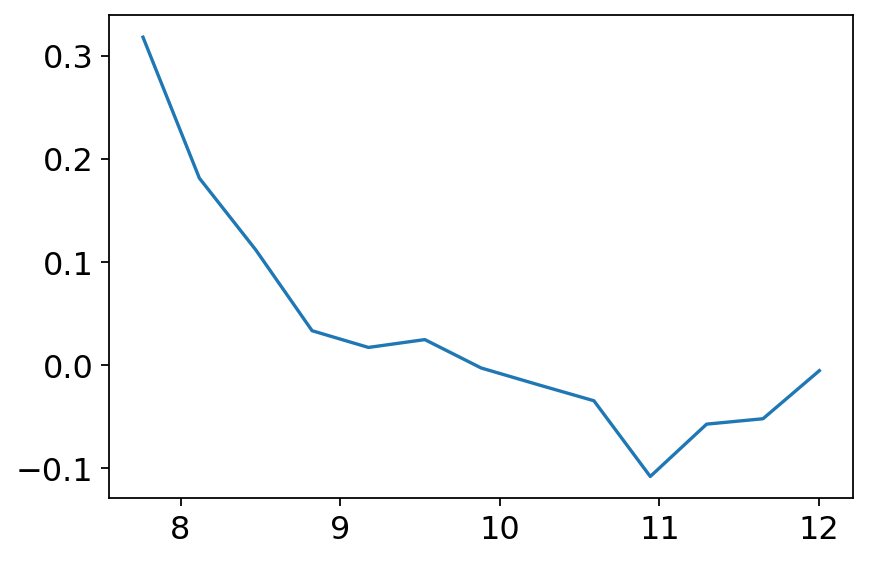

In [31]:
plot_error_fig(y_test_mult, y_pred_mult)

# sSFR1

In [324]:
y_label_name = 'ssfr1'

In [325]:
fit_tag = f'_{y_label_name}_nn'
fn_model = f'../models/models_{sim_name}/model_{sim_name}{halo_tag}{geo_tag}{scalar_tag}{fit_tag}.pt'
print(fn_model)

../models/models_TNG100-1/model_TNG100-1_ssfr1_nn.pt


In [326]:
y = utils.get_y_vals(y_label_name, sim_reader)
y_test = y[idx_test]

In [327]:
nnfitter = NNFitter()
nnfitter.load_model(fn_model)

(-1.0, 0.06266577252010719)

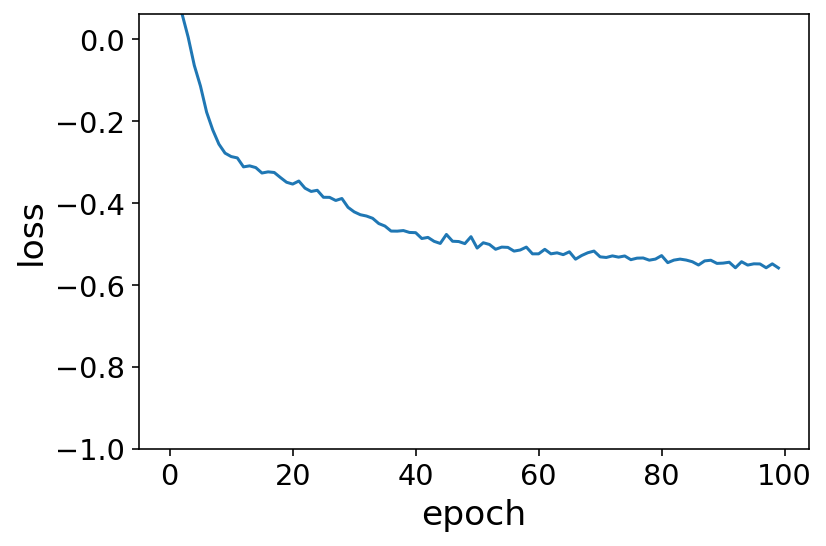

In [329]:
plt.plot(nnfitter.loss)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.ylim(-1, nnfitter.loss[2])

In [331]:
y_pred = nnfitter.predict(x_test, y_test_current, x_extra=x_test_extra)

/home/ksf293/equivariant-cosmology/notebooks/../code/utils.py:322: UserWarning: Trying to register the cmap 'shiftedcmap' which already exists.
  m_stellar_Msun_arr = (m_stellar_arr*mass_multiplier)/h


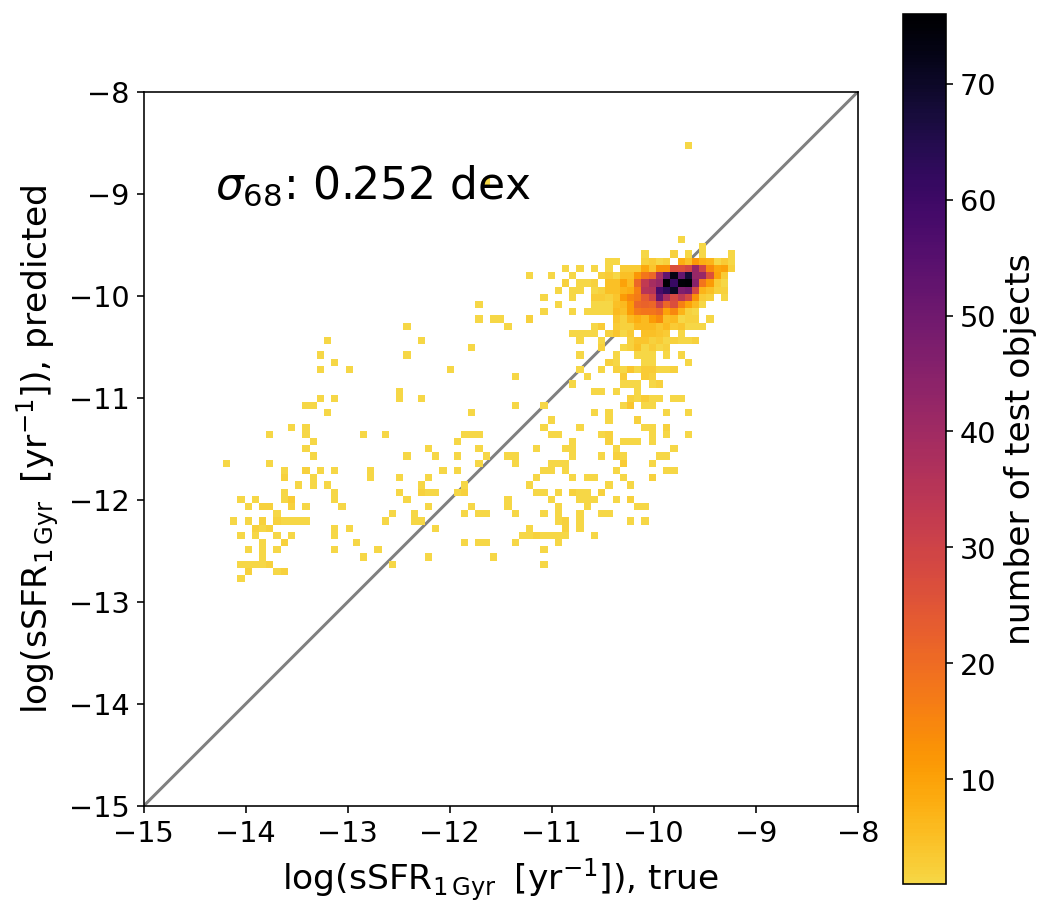

In [332]:
error_nn, _ = utils.compute_error(y_test, y_pred, test_error_type='percentile')
error_str = fr"$\sigma_{{68}}$: {error_nn:.3f} dex"
plotter.plot_pred_vs_true_hist(y_label_name, y_test, y_pred, text_results=error_str,
                               x_lim=(-15,-8),  y_lim=(-15,-8))

/home/ksf293/equivariant-cosmology/notebooks/../code/utils.py:322: UserWarning: Trying to register the cmap 'shiftedcmap' which already exists.
  m_stellar_Msun_arr = (m_stellar_arr*mass_multiplier)/h


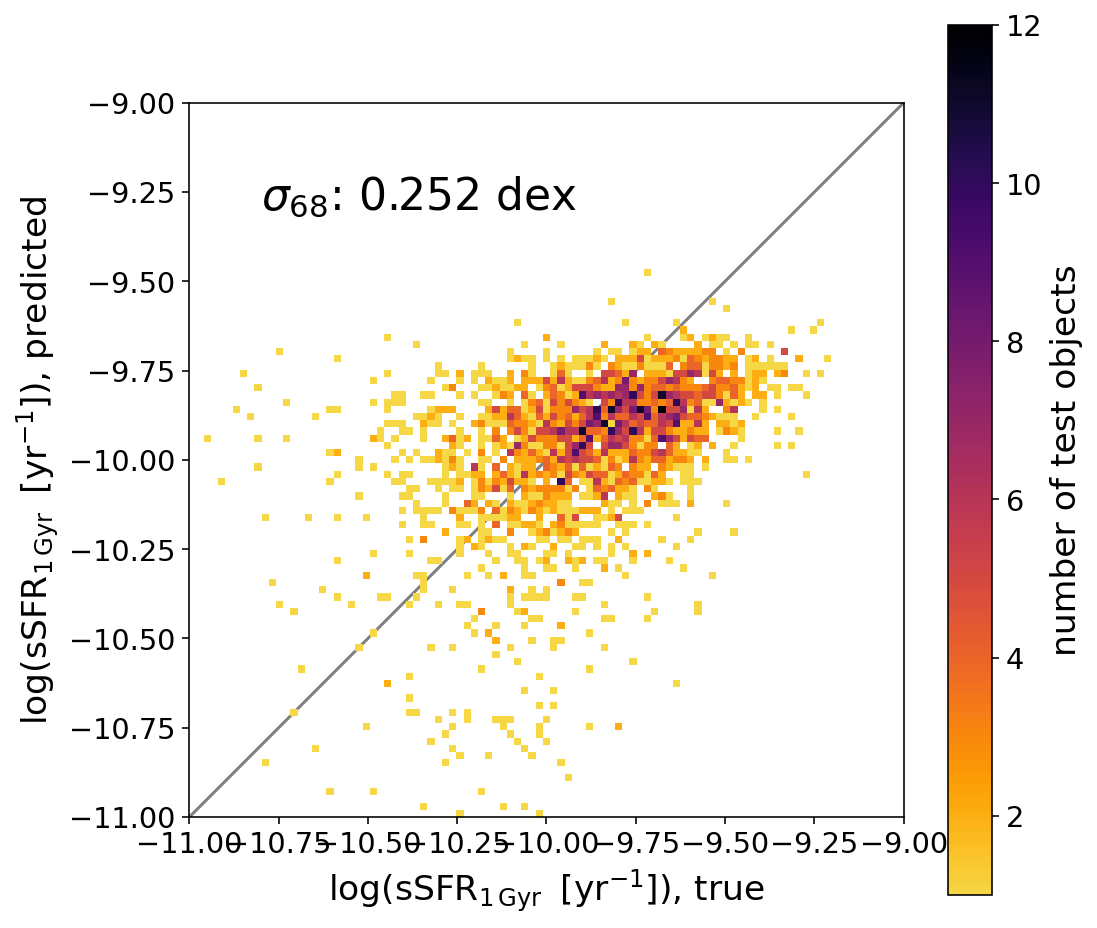

In [333]:
error_nn, _ = utils.compute_error(y_test, y_pred, test_error_type='percentile')
error_str = fr"$\sigma_{{68}}$: {error_nn:.3f} dex"
plotter.plot_pred_vs_true_hist(y_label_name, y_test, y_pred, text_results=error_str,
                               x_lim=(-11,-9),  y_lim=(-11,-9))

## Rstellar

In [70]:
y_label_name = 'r_stellar'

In [71]:
fit_tag = f'_{y_label_name}_nn'
fn_model = f'../models/models_{sim_name}/model_{sim_name}{halo_tag}{geo_tag}{scalar_tag}{fit_tag}.pt'

In [72]:
y = utils.get_y_vals(y_label_name, sim_reader)
y_test = y[idx_test]

In [76]:
nnfitter = NNFitter()
nnfitter.load_model(fn_model)

Text(0, 0.5, 'loss')

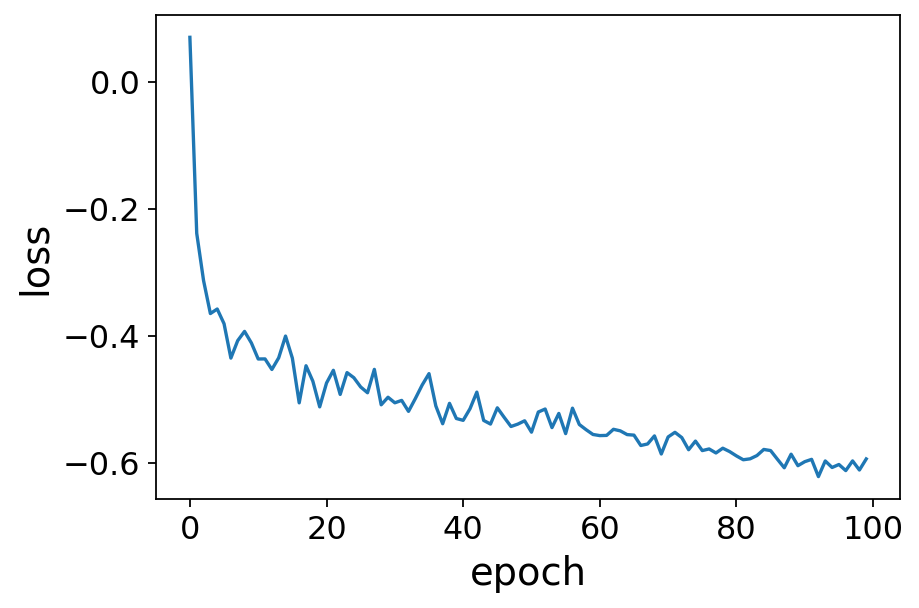

In [81]:
plt.plot(nnfitter.loss)
plt.xlabel('epoch')
plt.ylabel('loss')
#plt.ylim(0, nnfitter.loss[2])

In [78]:
y_pred = nnfitter.predict(x_test, y_test_current, x_extra=x_test_extra)

/home/ksf293/equivariant-cosmology/notebooks/../code/utils.py:314: UserWarning: Trying to register the cmap 'shiftedcmap' which already exists.
  newcmap = matplotlib.colors.LinearSegmentedColormap(name, cdict)


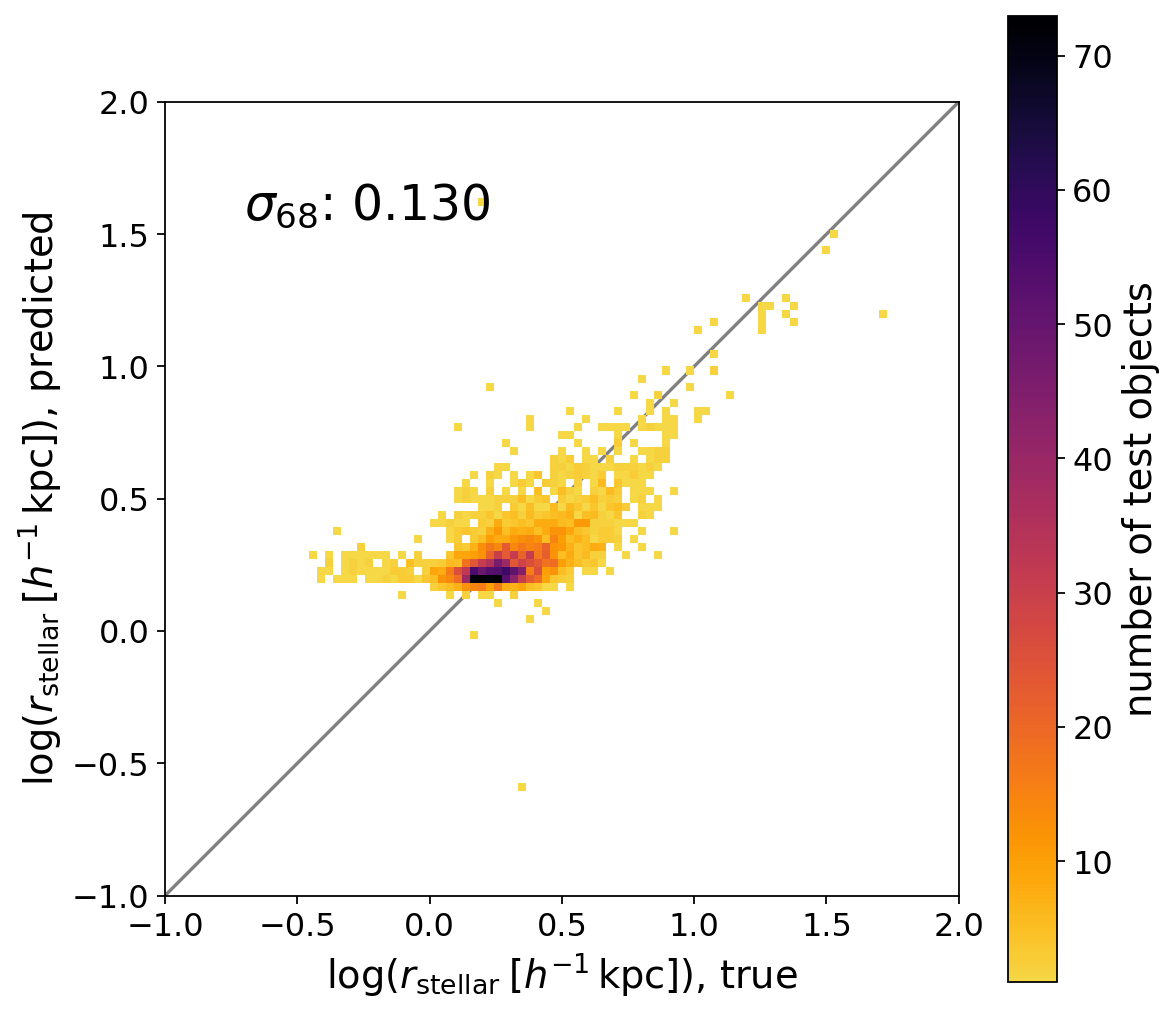

In [80]:
error_nn, _ = utils.compute_error(y_test, y_pred, test_error_type='percentile')
error_str = fr"$\sigma_{{68}}$: {error_nn:.3f}"
plotter.plot_pred_vs_true_hist(y_label_name, y_test, y_pred, text_results=error_str,
                               x_lim=(-1,2),  y_lim=(-1,2))

# MAH

## a_mfrac_0.5

In [54]:
y_label_name = 'a_mfrac_0.5'

In [55]:
#fit_tag = f'_{y_label_name}_nn_epochs1000_lr1e-3'
#fit_tag = f'_{y_label_name}_nn_epochs2500'
fit_tag = f'_{y_label_name}_nn_epochs2000'
#fit_tag = f'_{y_label_name}_nn'
fn_model = f'../models/models_{sim_name}/model_{sim_name}{halo_tag}{geo_tag}{scalar_tag}{fit_tag}.pt'

In [56]:
y = utils.get_y_vals(y_label_name, sim_reader, halo_tag=halo_tag)
y_test = y[idx_test]

In [57]:
nnfitter = NNFitter()
nnfitter.load_model(fn_model)

Text(0, 0.5, 'loss')

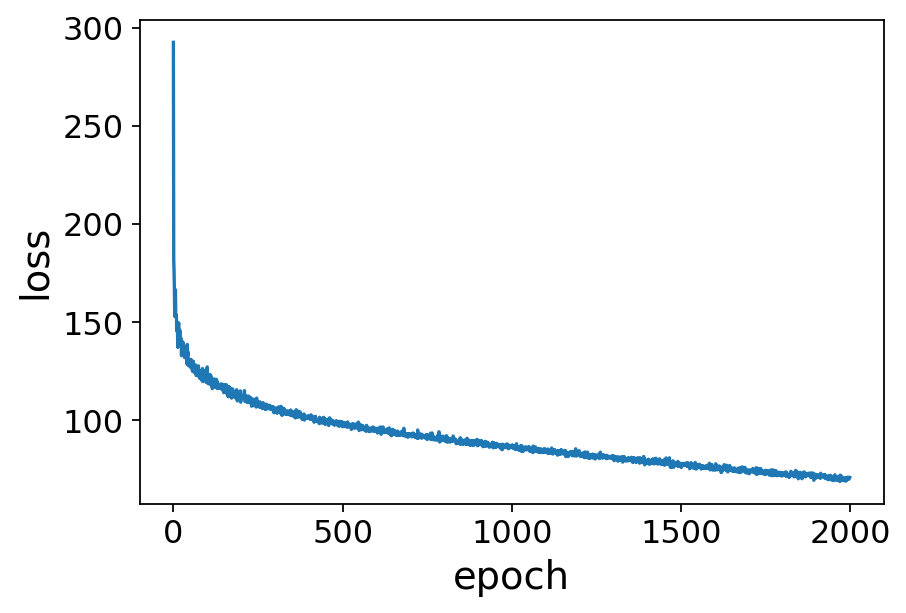

In [61]:
plt.plot(nnfitter.loss)

# plt.plot(nnfitter.loss_valid, color='darkorchid', label='Validation')
# plt.plot(nnfitter.loss_train, color='blue', label='Training')
plt.xlabel('epoch')
plt.ylabel('loss')
#plt.ylim(0, nnfitter.loss_train[2])
#print(np.min(nnfitter.loss_valid))
#plt.ylim(400, 500)

In [62]:
y_pred = nnfitter.predict(x_test, y_test_current, x_extra=x_test_extra)

/home/ksf293/equivariant-cosmology/notebooks/../code/utils.py:322: UserWarning: Trying to register the cmap 'shiftedcmap' which already exists.
  plt.register_cmap(cmap=newcmap)


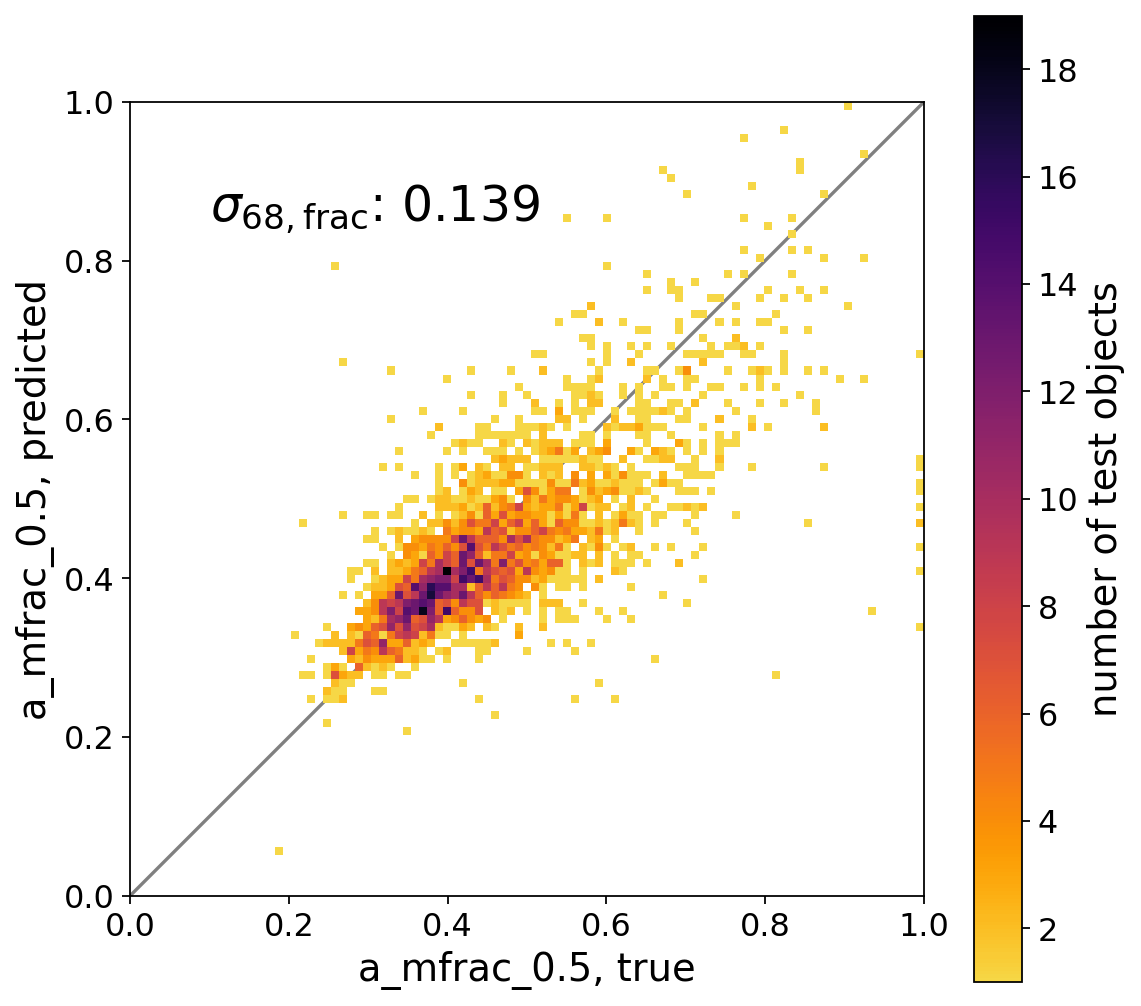

In [63]:
error_nn, _ = utils.compute_error(y_test, y_pred, test_error_type='percentile_frac')
error_str = fr"$\sigma_{{68,\mathrm{{frac}}}}$: {error_nn:.3f}"
plotter.plot_pred_vs_true_hist(y_label_name, y_test, y_pred, text_results=error_str,
                               x_lim=(0,1),  y_lim=(0,1))

## multi a_mfrac

In [64]:
y_label_name = 'a_mfrac_n21'

In [257]:
fit_tag = f'_{y_label_name}_nn'
fn_model = f'../models/models_{sim_name}/model_{sim_name}{halo_tag}{geo_tag}{scalar_tag}{fit_tag}.pt'

In [258]:
y = utils.get_y_vals(y_label_name, sim_reader, halo_tag=halo_tag)
y_test = y[idx_test]

In [259]:
idx_nan = np.isnan(y)
print(np.sum(idx_nan))

0


In [260]:
n = y_label_name.split('_n')[-1]
mfrac_vals = utils.get_mfrac_vals(int(n)) # should include 1 or no? now does
print(mfrac_vals)

[0.04545455 0.09090909 0.13636364 0.18181818 0.22727273 0.27272727
 0.31818182 0.36363636 0.40909091 0.45454545 0.5        0.54545455
 0.59090909 0.63636364 0.68181818 0.72727273 0.77272727 0.81818182
 0.86363636 0.90909091 0.95454545]


In [261]:
nnfitter = NNFitter()
nnfitter.load_model(fn_model)

(0.0, 190.4964874257303)

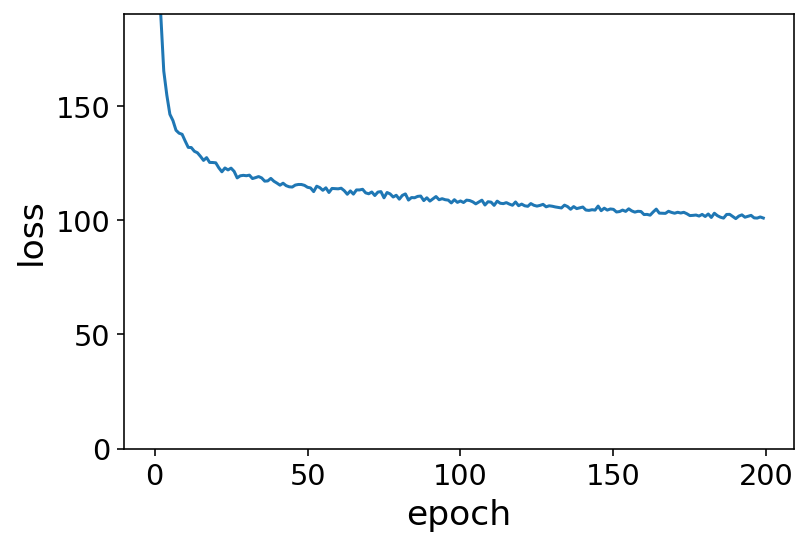

In [262]:
plt.plot(nnfitter.loss)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.ylim(0, nnfitter.loss[2])

In [263]:
y_pred = nnfitter.predict(x_test, y_test_current, x_extra=x_test_extra)

In [264]:
np.random.seed(14)
n_ex = 8
rand_idxs = np.random.randint(len(y_test), size=n_ex)

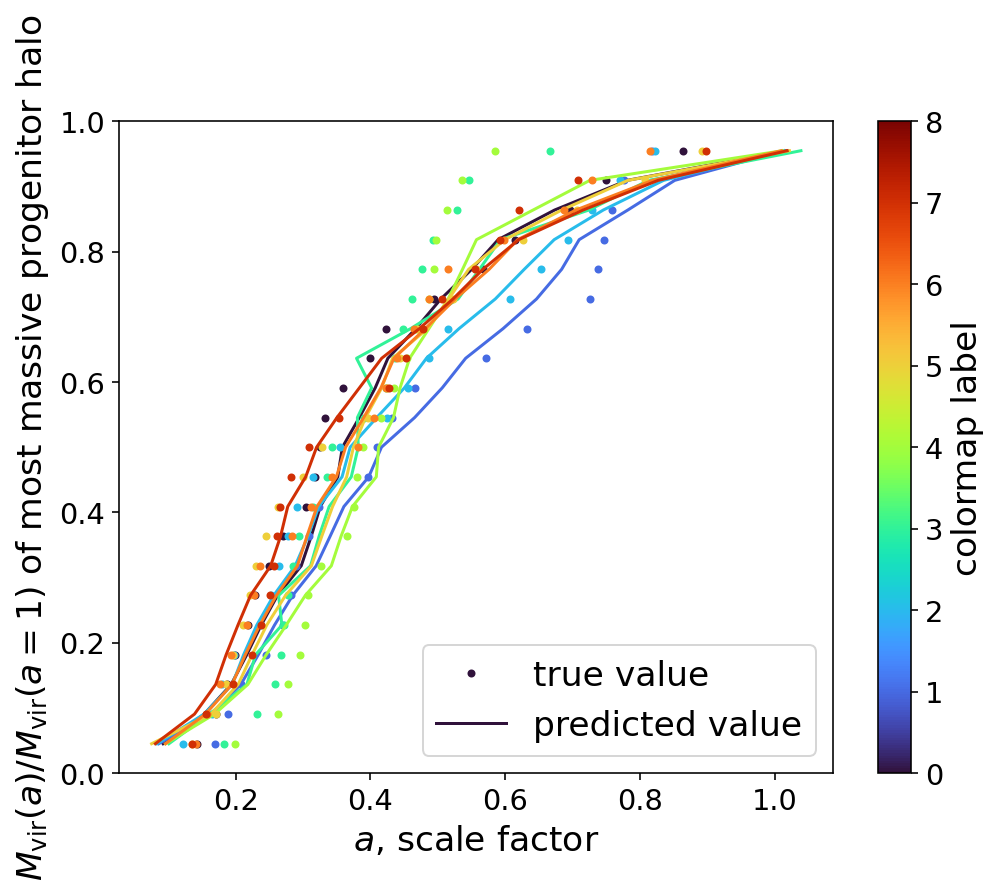

In [265]:
%matplotlib inline
plt.figure(figsize=(8,6))

locs_norm = matplotlib.colors.Normalize(vmin=0, vmax=n_ex)
cmap = matplotlib.cm.get_cmap('turbo')
colors = [cmap(locs_norm(i)) for i in range(n_ex)]

for i, i_rand in enumerate(rand_idxs):
    halo = sim_reader.dark_halo_arr[i_rand]
    #a_mah, m_mah = halo.catalog_properties['MAH']
    #plt.plot(a_mah, m_mah/m_mah[0], marker='o', markersize=3, ls='None')
    label_true, label_pred = None, None
    if i==0:
        label_true = 'true value'
        label_pred = 'predicted value'

    plt.plot(y_test[i_rand], mfrac_vals, marker='o', markersize=3, ls='None', color=colors[i], label=label_true)
    plt.plot(y_pred[i_rand], mfrac_vals, color=colors[i], label=label_pred)

#plt.yscale('log')
plt.xlabel(r'$a$, scale factor')
plt.ylabel(r'$M_\mathrm{vir}(a)$/$M_\mathrm{vir}(a=1)$ of most massive progenitor halo')

sm = plt.cm.ScalarMappable(cmap=cmap, norm=locs_norm)
plt.colorbar(sm, label='colormap label')
plt.legend()

In [59]:
def plot_a_mfrac_accuracy(a_pred, a_true, mfracs, title='', n_show=8):
    
    locs_norm = matplotlib.colors.Normalize(vmin=0, vmax=n_show)
    cmap = matplotlib.cm.get_cmap('turbo')
    colors = [cmap(locs_norm(i)) for i in range(n_show)]

    fig, (ax0, ax1, ax2) = plt.subplots(3, 1, sharex=True, gridspec_kw={'height_ratios': [2, 1, 1]},
                                  figsize=(6,8))
    plt.subplots_adjust(hspace=0.03)
    fig.suptitle(title, fontsize=16)

    errs = (a_pred - a_true)/a_true

    np.random.seed(14)
    rand_idxs_show = np.random.randint(len(a_true), size=n_show)
    for i, i_rand in enumerate(rand_idxs_show):
        halo = sim_reader.dark_halo_arr[i_rand]
        #a_mah, m_mah = halo.catalog_properties['MAH']
        #plt.plot(a_mah, m_mah/m_mah[0], marker='o', markersize=3, ls='None')

        label_true, label_pred = None, None
        if i==0:
            label_true = 'true value'
            label_pred = 'predicted value'

        ax0.plot(mfracs, a_true[i_rand], marker='o', markersize=4, ls='None', color=colors[i], label=label_true)
        ax0.plot(mfracs, a_pred[i_rand], color=colors[i], label=label_pred)

        ax1.plot(mfracs, errs[i_rand], color=colors[i])

    p16 = np.percentile(errs, 16, axis=0)
    p84 = np.percentile(errs, 84, axis=0)
    sig68_avg = 0.5*(p84-p16)
    ax2.plot(mfracs, p16, color='k', lw=2, label='prediction error')
    ax2.plot(mfracs, p84, color='k', lw=2)
    ax2.axhline(0.0, color='grey', lw=1)

    # print errors
    mfracs_to_print_err = [0.25, 0.5, 0.75]
    errs_to_print = []
    for mfrac in mfracs_to_print_err:
        _, idx_mfrac = utils.find_nearest(mfracs, mfrac)
        errs_to_print.append(rf"$\sigma_{{68}}(M/M_{{a=1}}={mfrac:.2f}) = {sig68_avg[idx_mfrac]:.3f}$")
    
    ax0.text(0.4, 0.1, '\n'.join(errs_to_print), fontsize=14)

    # TODO: this should be based on training set, not test, i think!
    y_test_mean = np.mean(y_test, axis=0)
    sample_var = (y_test - y_test_mean)/y_test_mean
    sample_p16 = np.percentile(sample_var, 16, axis=0)
    sample_p84 = np.percentile(sample_var, 84, axis=0)
    ax2.fill_between(mfracs, sample_p16, sample_p84, color='blue', lw=2, alpha=0.3, label='sample variance')

    ax0.set_ylabel(r'$a$, scale factor')
    ax1.set_ylabel(r'$(a_\mathrm{pred}-a_\mathrm{true})/a_\mathrm{true}$')
    ax2.set_ylabel(r'$\sigma_{68}$')

    ax2.set_xlabel(r'$M_\mathrm{vir}(a)$/$M_\mathrm{vir}(a=1)$ of most massive progenitor halo')

    ax0.set_ylim(0,1)
    ax1.axhline(0.0, color='grey', lw=1)

    ax0.legend(fontsize=14, loc='upper left')
    ax2.legend(fontsize=14)

In [277]:
error, _ = utils.compute_error(y_test, y_pred, test_error_type='percentile')
print(error)

[0.03612292 0.03273374 0.03711058 0.04074182 0.04406585 0.0474981
 0.05275816 0.05517443 0.05907459 0.06110103 0.06554398 0.06783832
 0.06869006 0.06926685 0.07092846 0.07298388 0.07467133 0.07765788
 0.08428676 0.08837217 0.10606411]


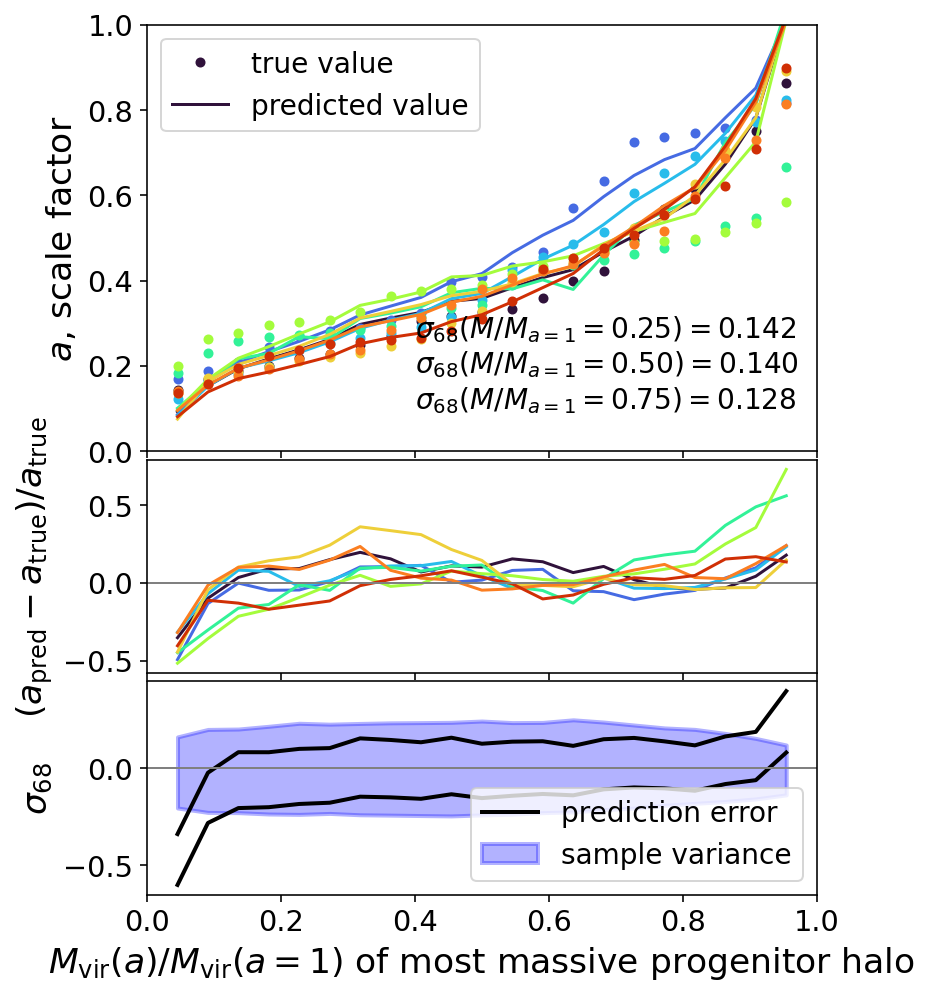

In [278]:
plot_a_mfrac_accuracy(y_pred, y_test, mfrac_vals, title='')

10.417615 14.303833


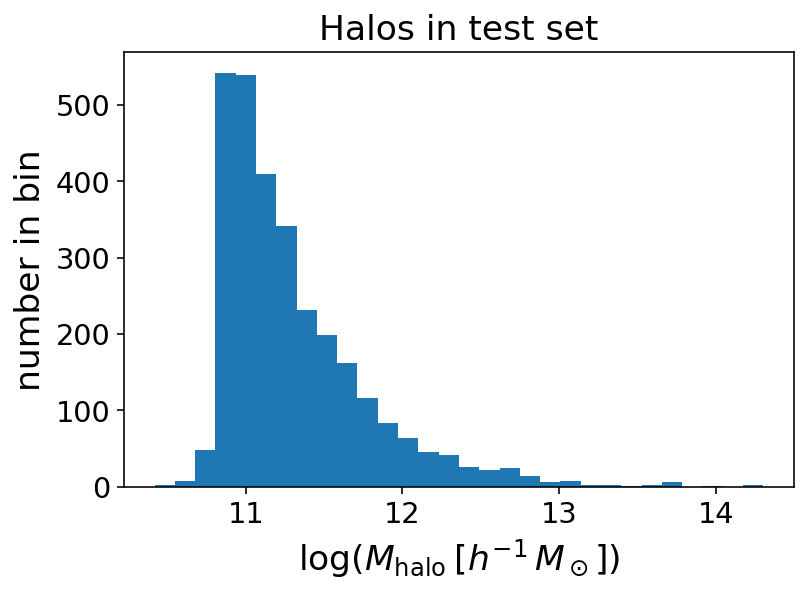

In [125]:
plt.title('Halos in test set')
plt.hist(log_m_200m[idx_test]+log_mass_shift, bins=30)
plt.xlabel(utils.label_dict['m_200m'])
plt.ylabel('number in bin')
print(np.min(log_m_200m[idx_test]+log_mass_shift), np.max(log_m_200m[idx_test]+log_mass_shift))

Uhh i thought that 10.8 was our min halo mass... TODO investigate!! 

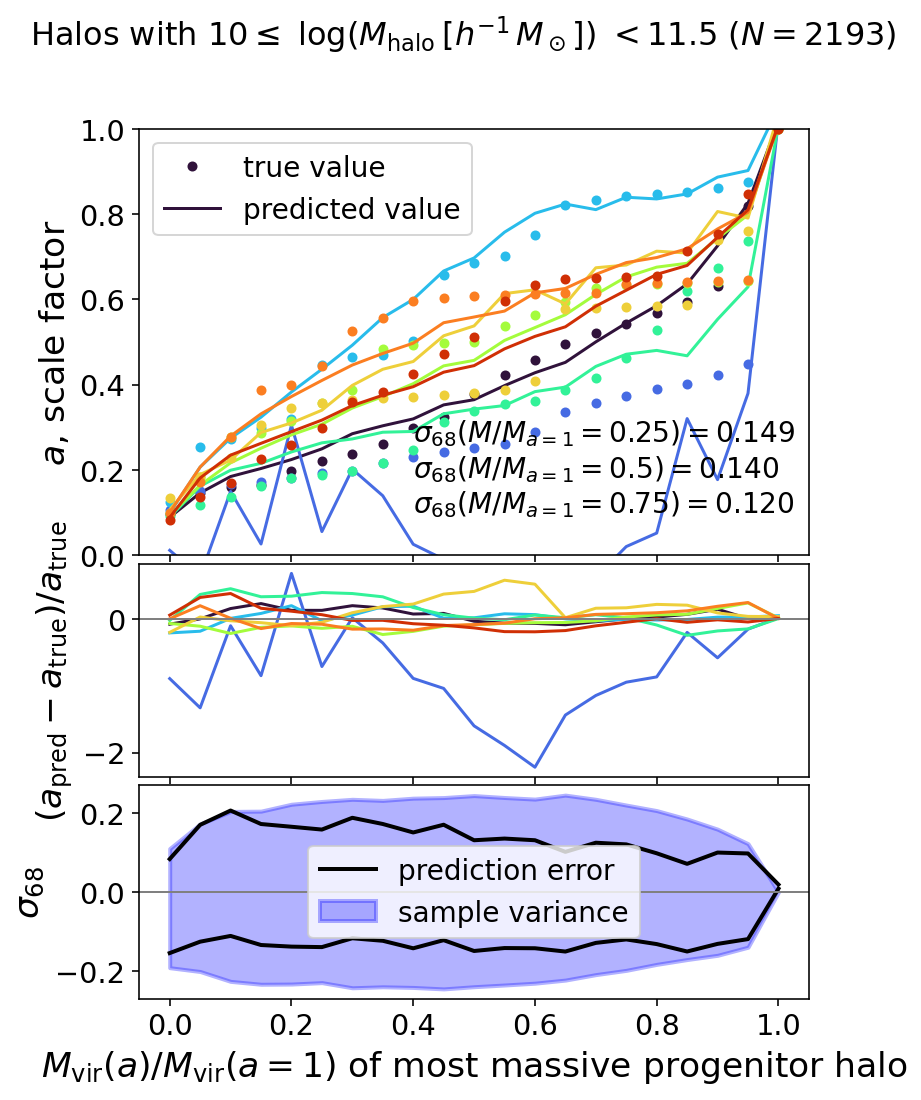

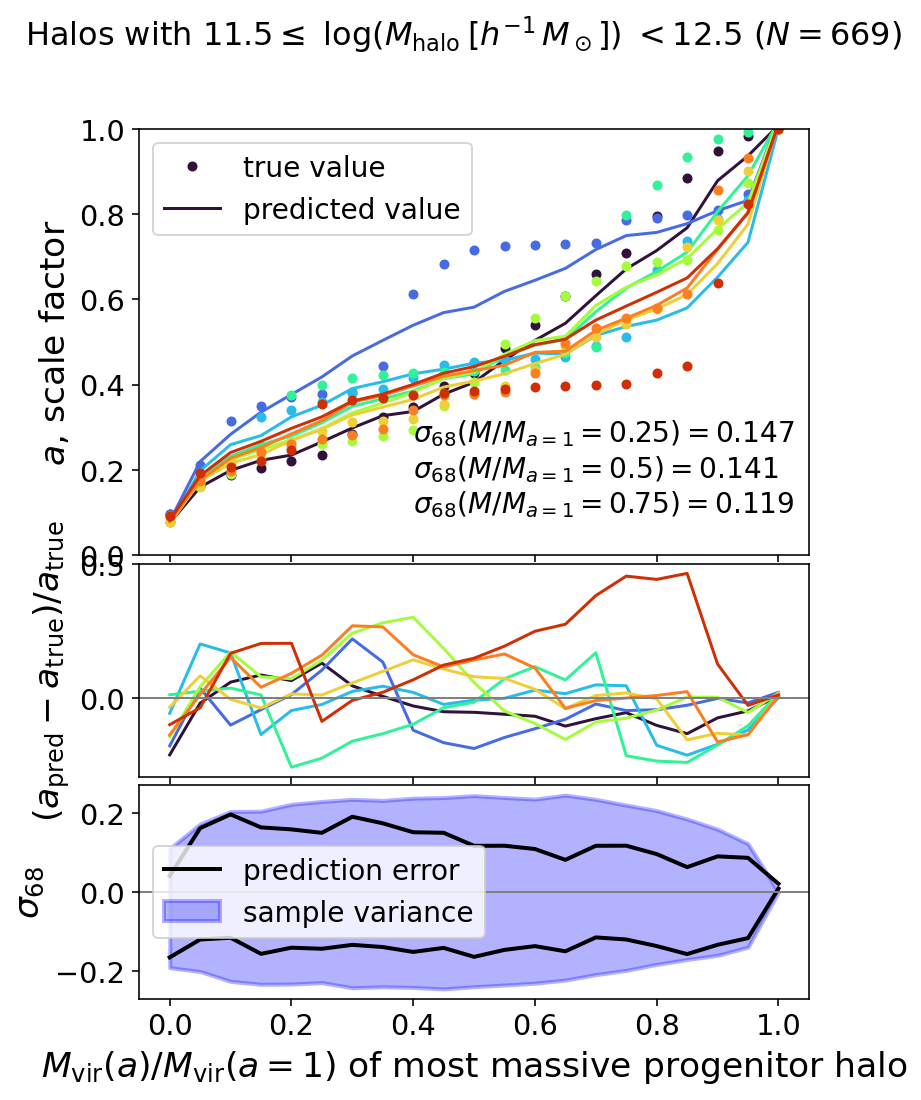

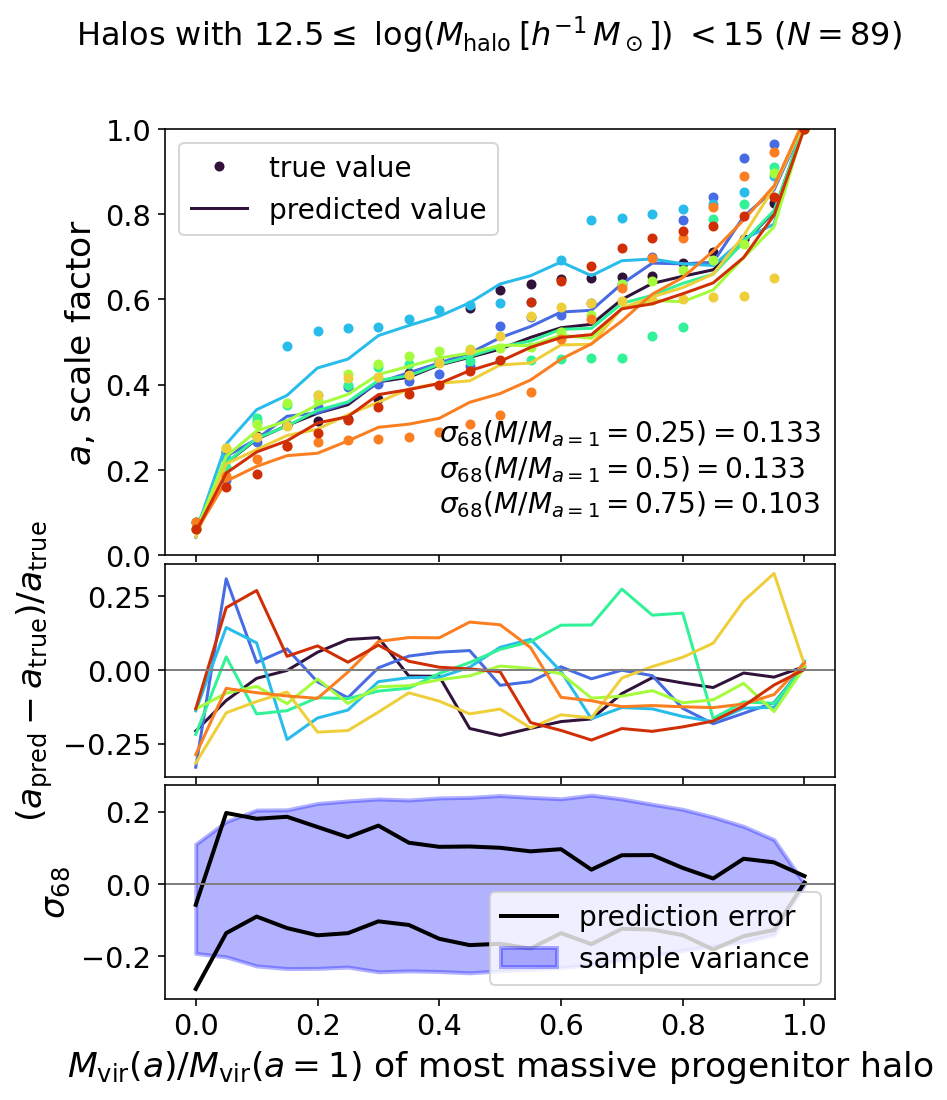

In [128]:
%matplotlib inline

m200m_bins = [10, 11.5, 12.5, 15]
logms_test = log_m_200m[idx_test]+log_mass_shift

for i in range(len(m200m_bins)-1):
    idx_test_inbin = (logms >= m200m_bins[i]) & (logms < m200m_bins[i+1])
    n = np.sum(idx_test_inbin)
    title = rf"Halos with ${m200m_bins[i]} \leq$ {utils.label_dict['m_200m']} $< {m200m_bins[i+1]}$ $(N={n})$"
    plot_a_mfrac_accuracy(y_pred[idx_test_inbin], y_test[idx_test_inbin], mfrac_vals, title=title)

(-0.5, 0.5)

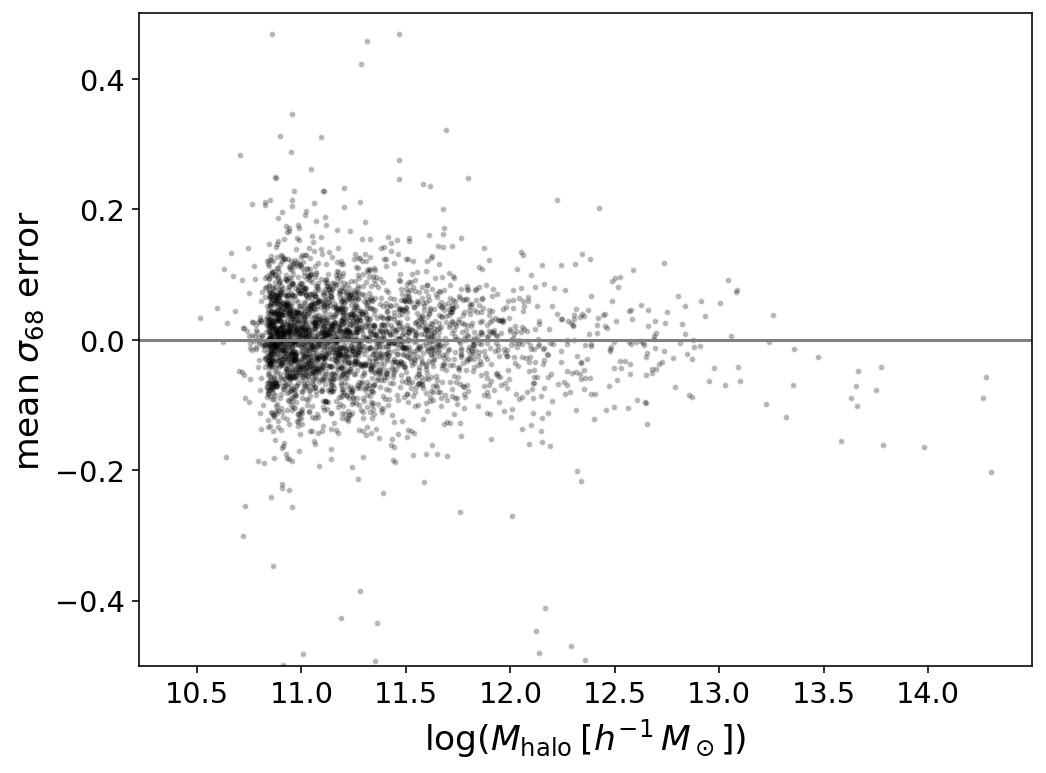

In [129]:
errs = (y_pred - y_test)/y_test
mean_errs = np.mean(errs, axis=1)

plt.figure(figsize=(8,6))
plt.scatter(logms_test, mean_errs, color='k', s=4, alpha=0.2)
plt.axhline(0.0, color='grey')
plt.xlabel(utils.label_dict['m_200m'])
plt.ylabel(r'mean $\sigma_{68}$ error')
plt.ylim(-0.5, 0.5)


# mfrac w fewer points

## multi a_mfrac

In [129]:
y_label_name = 'a_mfrac_n3'

In [130]:
#fit_tag = f'_{y_label_name}_nn'
fit_tag = f'_{y_label_name}_nn_epochs2500'
fn_model = f'../models/models_{sim_name}/model_{sim_name}{halo_tag}{geo_tag}{scalar_tag}{fit_tag}.pt'

In [131]:
y = utils.get_y_vals(y_label_name, sim_reader, halo_tag=halo_tag)
y_test = y[idx_test]

In [132]:
n = y_label_name.split('_n')[-1]
mfrac_vals = utils.get_mfrac_vals(int(n)) # should include 1 or no? now does
print(mfrac_vals)

[0.25 0.5  0.75]


In [133]:
nnfitter = NNFitter()
nnfitter.load_model(fn_model)

Text(0, 0.5, 'loss')

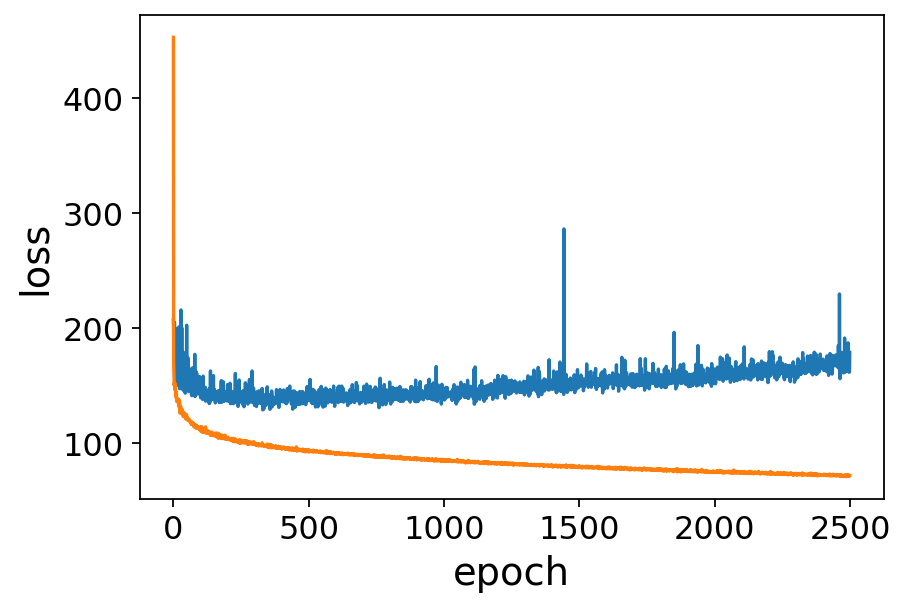

In [140]:
plt.plot(nnfitter.loss_valid)
plt.plot(nnfitter.loss_train)
plt.xlabel('epoch')
plt.ylabel('loss')
#plt.ylim(0, nnfitter.loss[2])
#print(np.min(nnfitter.loss))

In [136]:
y_pred = nnfitter.predict(x_test, y_test_current, x_extra=x_test_extra)

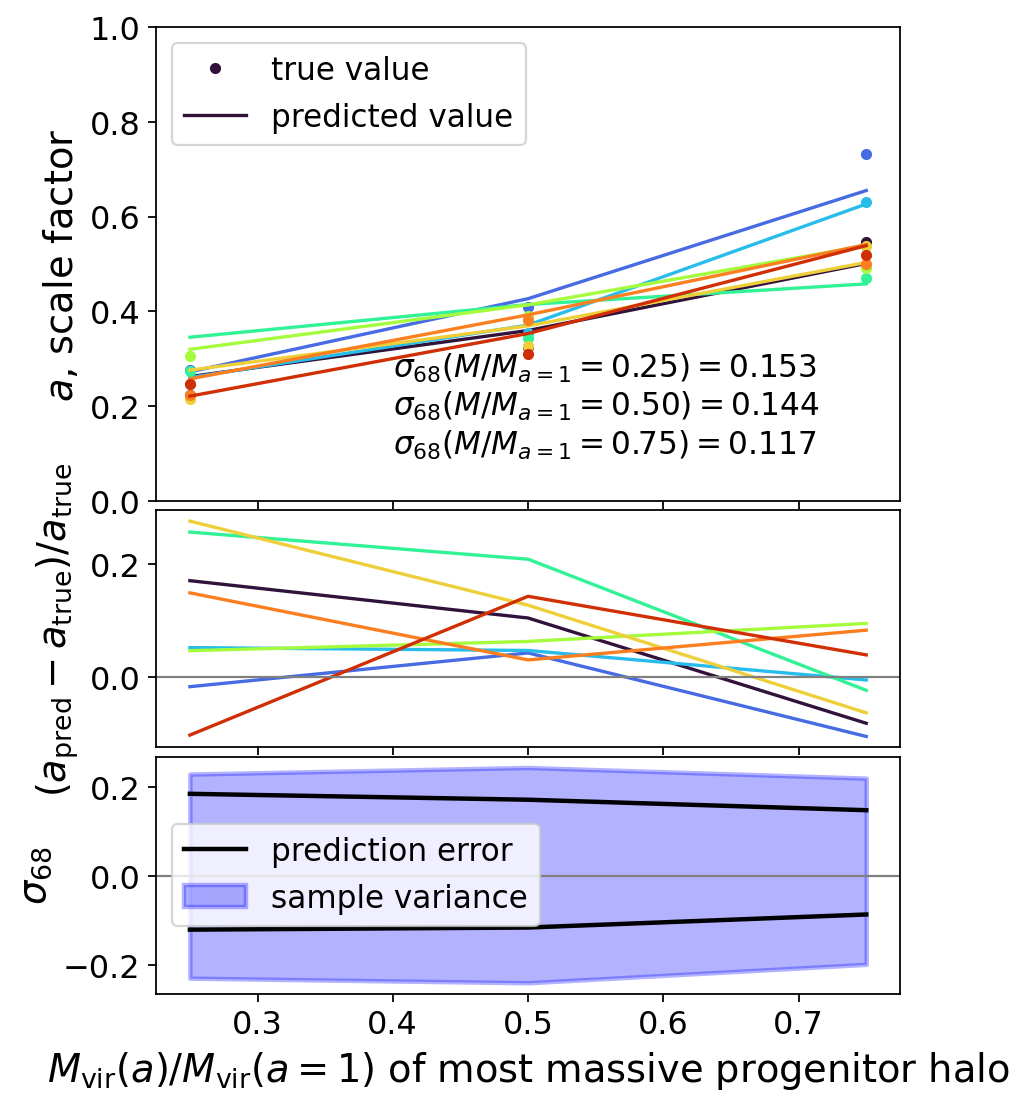

In [137]:
plot_a_mfrac_accuracy(y_pred, y_test, mfrac_vals, title='', n_show=8)

## multi a_mfrac

In [121]:
y_label_name = 'a_mfrac_n7'

In [122]:
#fit_tag = f'_{y_label_name}_nn'
fit_tag = f'_{y_label_name}_nn_epochs2000'
fn_model = f'../models/models_{sim_name}/model_{sim_name}{halo_tag}{geo_tag}{scalar_tag}{fit_tag}.pt'

In [123]:
y = utils.get_y_vals(y_label_name, sim_reader, halo_tag=halo_tag)
y_test = y[idx_test]

In [124]:
n = y_label_name.split('_n')[-1]
mfrac_vals = utils.get_mfrac_vals(int(n)) # should include 1 or no? now does
print(mfrac_vals)

[0.125 0.25  0.375 0.5   0.625 0.75  0.875]


In [125]:
nnfitter = NNFitter()
nnfitter.load_model(fn_model)

79.09826313830736


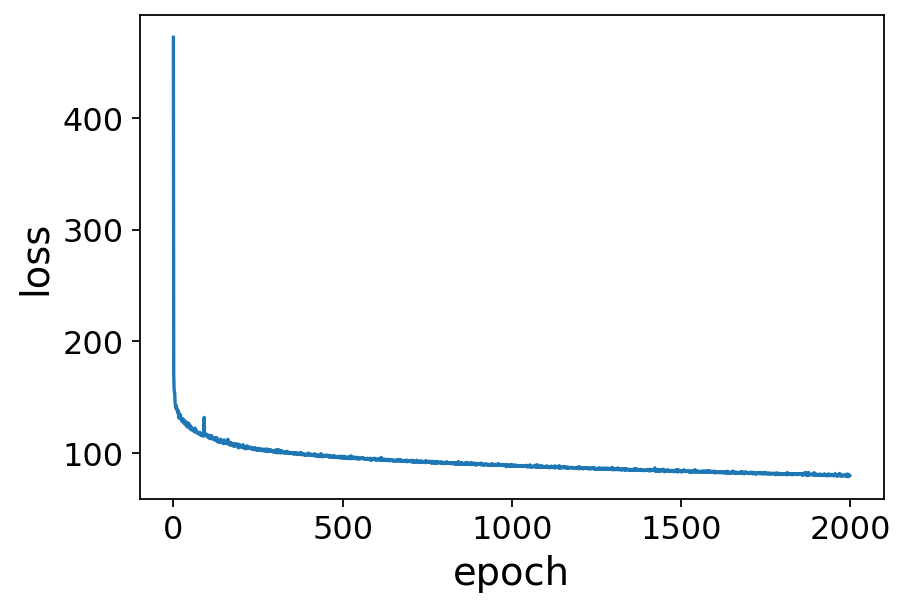

In [126]:
plt.plot(nnfitter.loss)
plt.xlabel('epoch')
plt.ylabel('loss')
#plt.ylim(0, nnfitter.loss[2])
print(np.min(nnfitter.loss))

In [127]:
y_pred = nnfitter.predict(x_test, y_test_current, x_extra=x_test_extra)

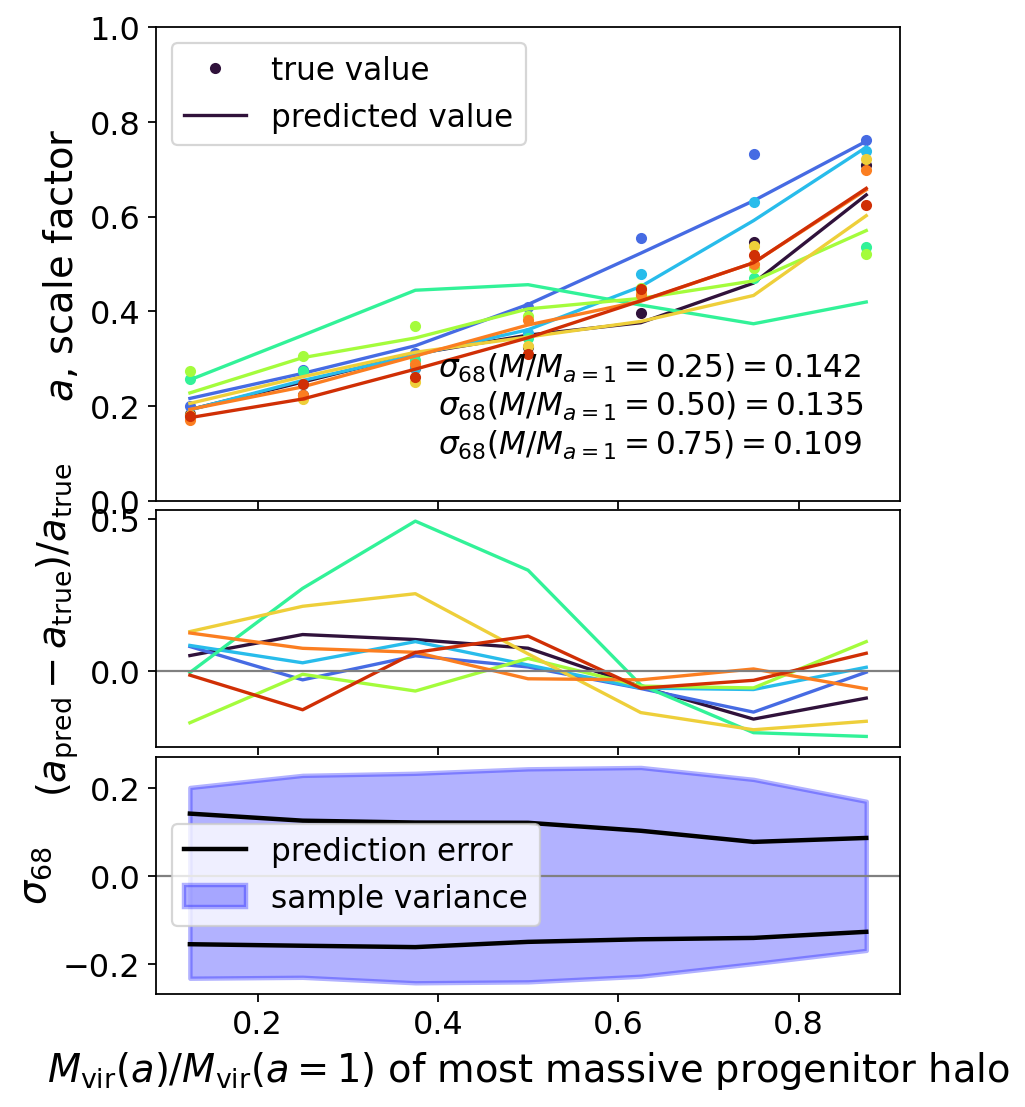

In [128]:
plot_a_mfrac_accuracy(y_pred, y_test, mfrac_vals, title='', n_show=8)

## multi a_mfrac

In [100]:
y_label_name = 'a_mfrac_n19'

In [101]:
#fit_tag = f'_{y_label_name}_nn'
fit_tag = f'_{y_label_name}_nn_epochs2500'
fn_model = f'../models/models_{sim_name}/model_{sim_name}{halo_tag}{geo_tag}{scalar_tag}{fit_tag}.pt'

In [102]:
y = utils.get_y_vals(y_label_name, sim_reader, halo_tag=halo_tag)
y_test = y[idx_test]

In [103]:
n = y_label_name.split('_n')[-1]
mfrac_vals = utils.get_mfrac_vals(int(n)) # should include 1 or no? now does
print(mfrac_vals)

[0.05 0.1  0.15 0.2  0.25 0.3  0.35 0.4  0.45 0.5  0.55 0.6  0.65 0.7
 0.75 0.8  0.85 0.9  0.95]


In [104]:
nnfitter = NNFitter()
nnfitter.load_model(fn_model)

132.34264831802184


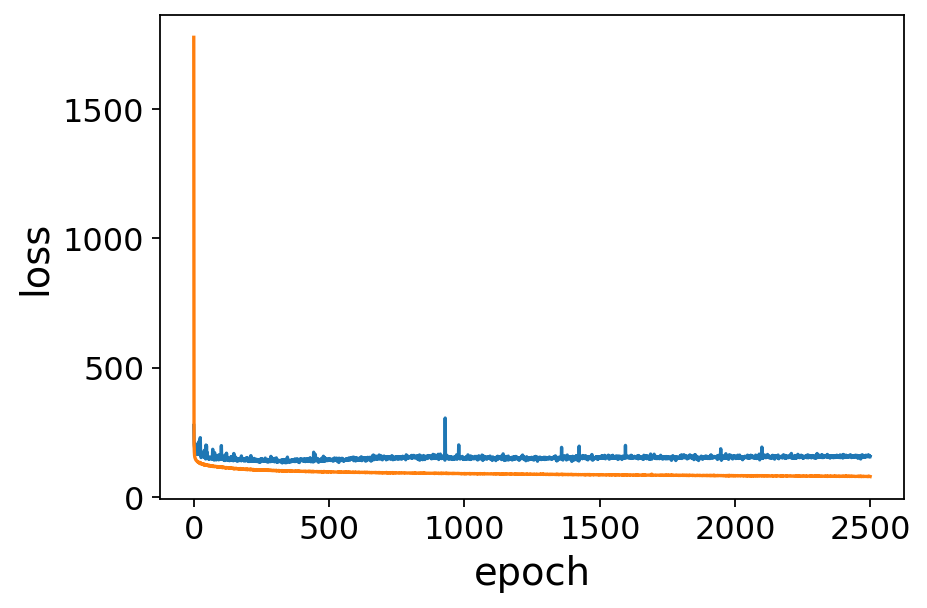

In [105]:
plt.plot(nnfitter.loss_valid)
plt.plot(nnfitter.loss_train)
plt.xlabel('epoch')
plt.ylabel('loss')
#plt.ylim(0, nnfitter.loss[2])
print(np.min(nnfitter.loss_valid))

In [106]:
y_pred = nnfitter.predict(x_test, y_test_current, x_extra=x_test_extra)

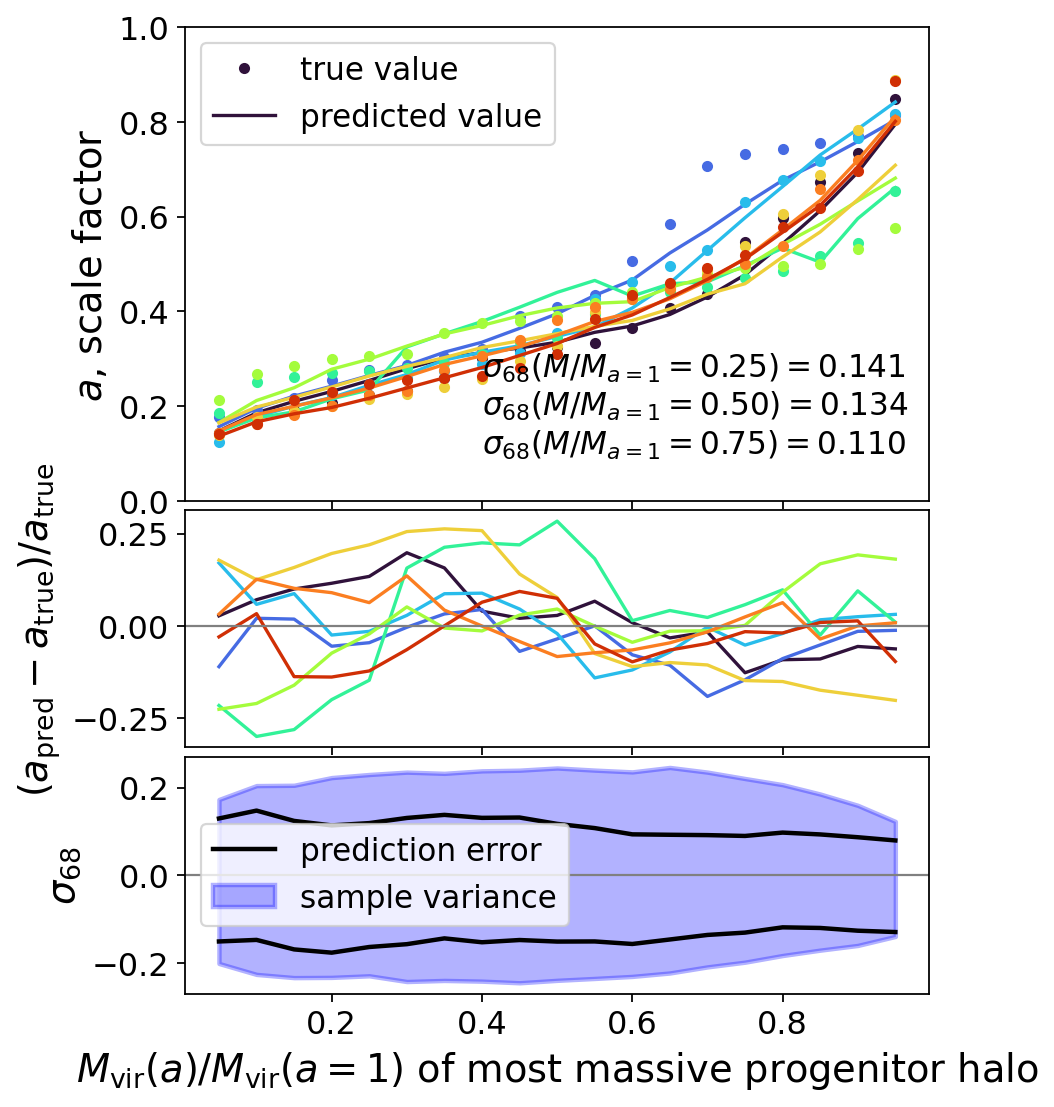

In [107]:
plot_a_mfrac_accuracy(y_pred, y_test, mfrac_vals, title='', n_show=8)

# n39

In [108]:
y_label_name = 'a_mfrac_n39'

In [109]:
#fit_tag = f'_{y_label_name}_nn'
fit_tag = f'_{y_label_name}_nn_epochs2500'
fn_model = f'../models/models_{sim_name}/model_{sim_name}{halo_tag}{geo_tag}{scalar_tag}{fit_tag}.pt'

In [110]:
y = utils.get_y_vals(y_label_name, sim_reader, halo_tag=halo_tag)
y_test = y[idx_test]

In [111]:
n = y_label_name.split('_n')[-1]
mfrac_vals = utils.get_mfrac_vals(int(n)) # should include 1 or no? now does
print(mfrac_vals)

[0.025 0.05  0.075 0.1   0.125 0.15  0.175 0.2   0.225 0.25  0.275 0.3
 0.325 0.35  0.375 0.4   0.425 0.45  0.475 0.5   0.525 0.55  0.575 0.6
 0.625 0.65  0.675 0.7   0.725 0.75  0.775 0.8   0.825 0.85  0.875 0.9
 0.925 0.95  0.975]


In [112]:
nnfitter = NNFitter()
nnfitter.load_model(fn_model)

127.94662279678877


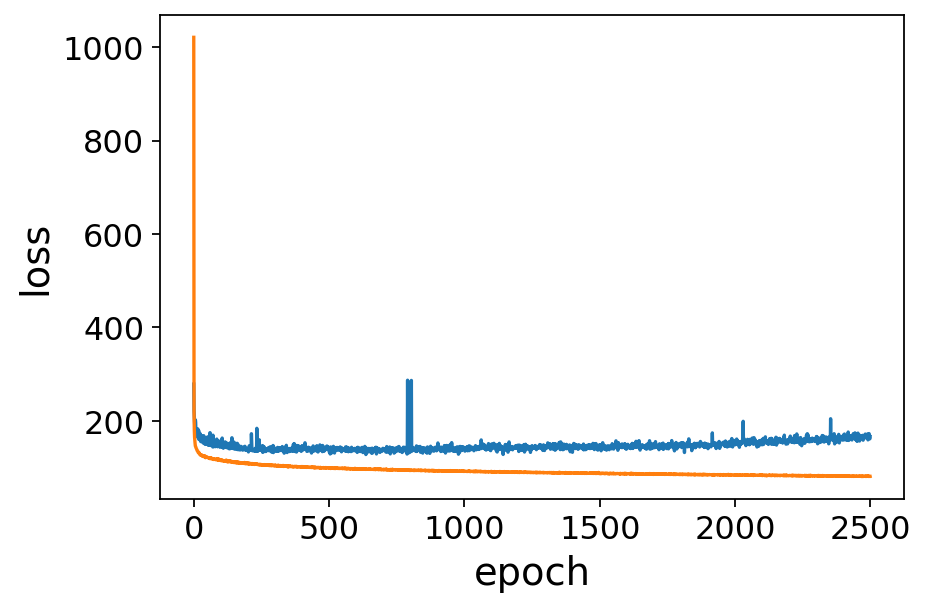

In [113]:
plt.plot(nnfitter.loss_valid)
plt.plot(nnfitter.loss_train)
plt.xlabel('epoch')
plt.ylabel('loss')
#plt.ylim(0, nnfitter.loss[2])
print(np.min(nnfitter.loss_valid))

In [114]:
y_pred = nnfitter.predict(x_test, y_test_current, x_extra=x_test_extra)

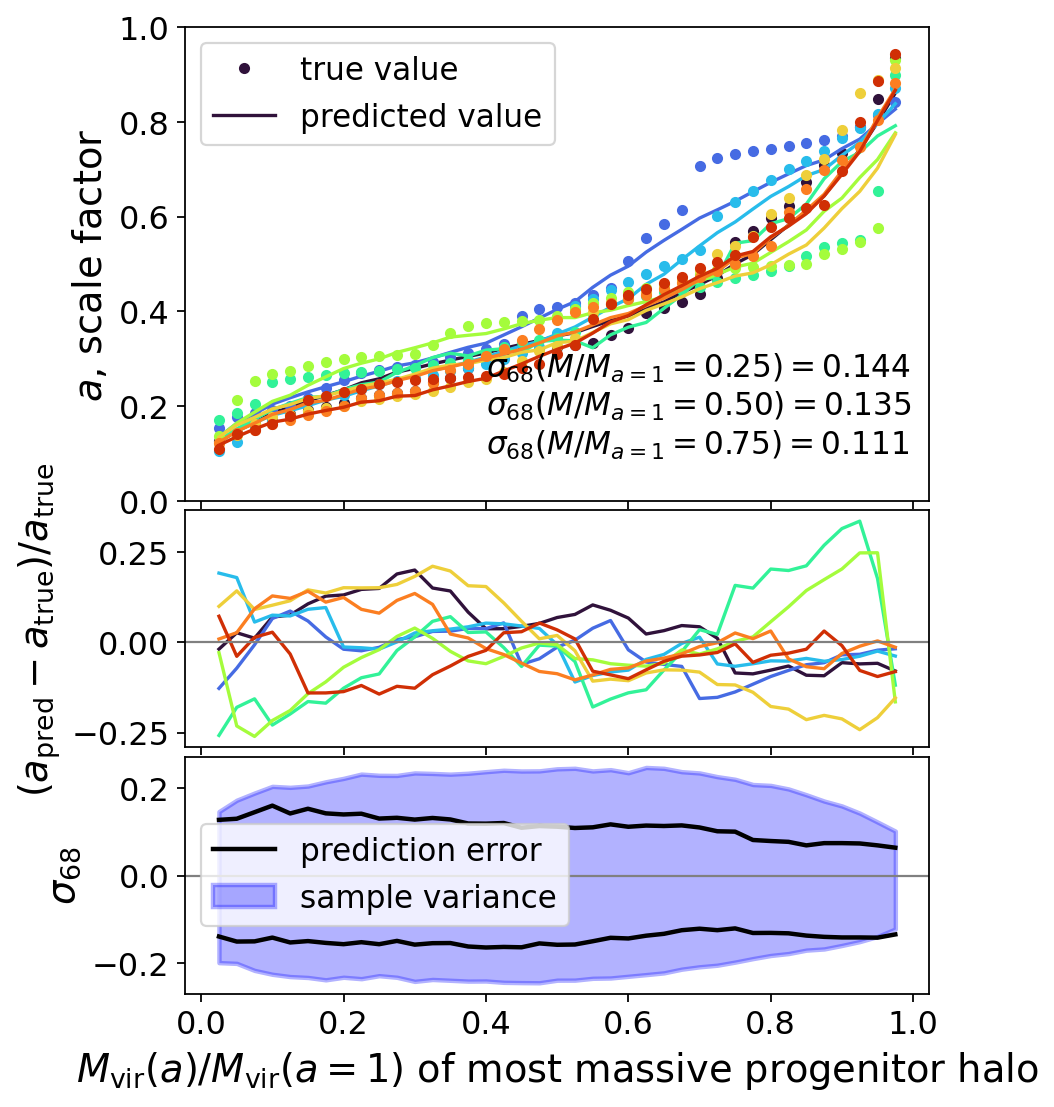

In [115]:
plot_a_mfrac_accuracy(y_pred, y_test, mfrac_vals, title='', n_show=8)

residual (frac err) as function of a (for a few mass fractions)

In [ ]:
m_fracs = [0.25, 0.5, 0.75]

# n39

In [46]:
y_label_name = 'a_mfrac_n39'

In [52]:
#fit_tag = f'_{y_label_name}_nn'
max_epochs = 1000
lr = 0.0001
hidden_size = 128
feature_mode = 'scalars'
fit_tag = f'_{y_label_name}_nn_{feature_mode}_epochs{max_epochs}_lr{lr}_hs{hidden_size}'
fn_model = f'../models/models_{sim_name}/model_{sim_name}{halo_tag}{geo_tag}{scalar_tag}{fit_tag}.pt'

In [53]:
y = utils.get_y_vals(y_label_name, sim_reader, halo_tag=halo_tag)
y_test = y[idx_test]

In [54]:
n = y_label_name.split('_n')[-1]
mfrac_vals = utils.get_mfrac_vals(int(n)) # should include 1 or no? now does
print(mfrac_vals)

[0.025 0.05  0.075 0.1   0.125 0.15  0.175 0.2   0.225 0.25  0.275 0.3
 0.325 0.35  0.375 0.4   0.425 0.45  0.475 0.5   0.525 0.55  0.575 0.6
 0.625 0.65  0.675 0.7   0.725 0.75  0.775 0.8   0.825 0.85  0.875 0.9
 0.925 0.95  0.975]


In [55]:
nnfitter = NNFitter()
nnfitter.load_model(fn_model)

3.09842935104703


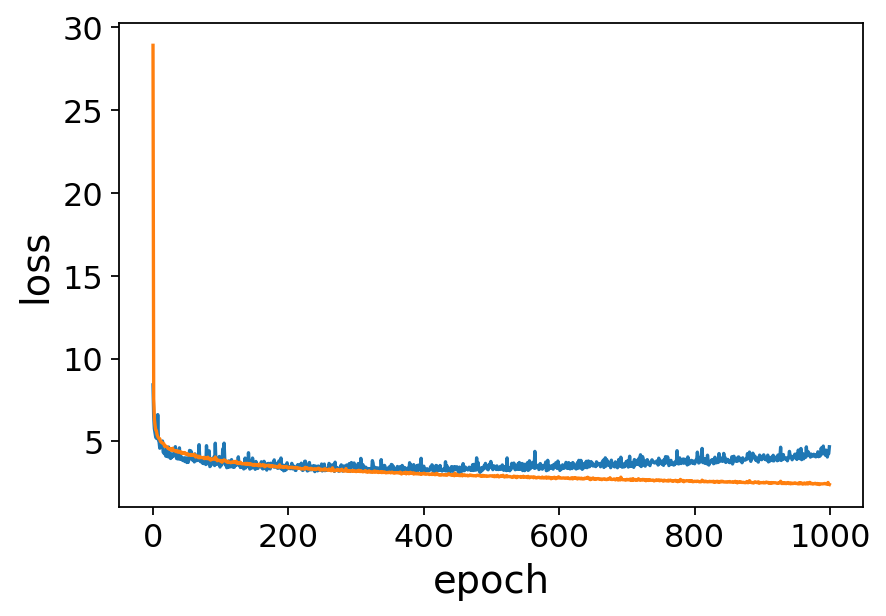

In [56]:
plt.plot(nnfitter.loss_valid)
plt.plot(nnfitter.loss_train)
plt.xlabel('epoch')
plt.ylabel('loss')
#plt.ylim(0, nnfitter.loss[2])
print(np.min(nnfitter.loss_valid))

In [57]:
y_pred = nnfitter.predict(x_test, y_test_current, x_extra=x_test_extra)

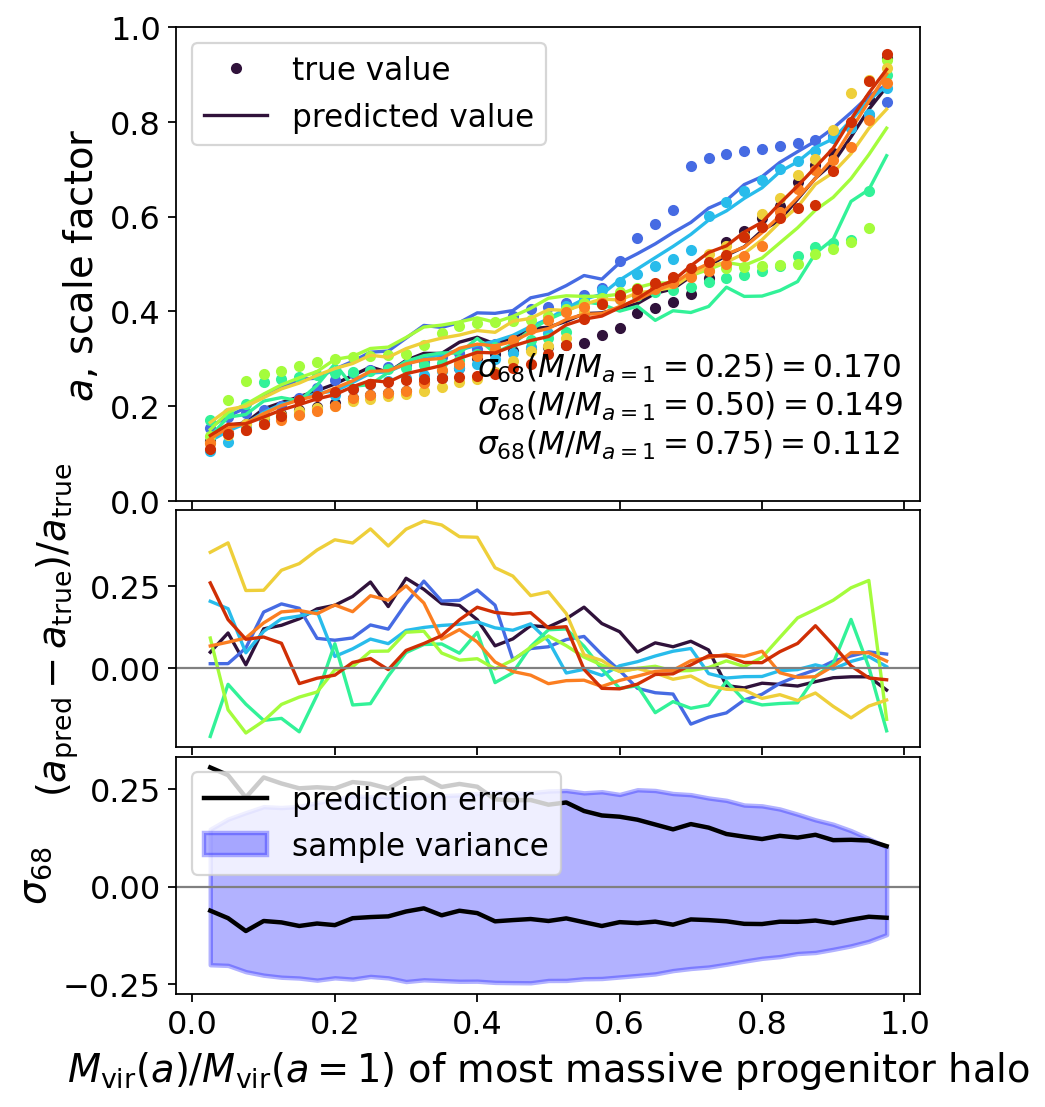

In [60]:
plot_a_mfrac_accuracy(y_pred, y_test, mfrac_vals, title='', n_show=8)

residual (frac err) as function of a (for a few mass fractions)

# mfracs single together

In [ ]:
mfrac_vals = [0.75]

In [148]:
y = []
for mfrac in mfrac_vals:
    y_label_name = 'a_mfrac_{mfrac}'
    fit_tag = f'_{y_label_name}_nn'
    fn_model = f'../models/models_{sim_name}/model_{sim_name}{halo_tag}{geo_tag}{scalar_tag}{fit_tag}.pt'
    y_single = utils.get_y_vals(y_label_name, sim_reader, halo_tag=halo_tag)
    y.append(y_single)

y = np.array(y).T
print(y.shape)

In [ ]:
y_test = y[]

In [ ]:
y_pred = []
for mfrac in mfrac_vals:
    
    nnfitter = NNFitter()
    nnfitter.load_model(fn_model)
    y_pred = nnfitter.predict(x_test, y_test_current, x_extra=x_test_extra)
    

y = np.array(y).T
print(y.shape)

In [151]:
n = y_label_name.split('_n')[-1]
mfrac_vals = utils.get_mfrac_vals(int(n)) # should include 1 or no? now does
print(mfrac_vals)

[0.25 0.5  0.75]


# Mofa 

In [13]:
def plot_Mofa_accuracy(M_pred, M_true, avals, title='', n_show=8):
    
    locs_norm = matplotlib.colors.Normalize(vmin=0, vmax=n_show)
    cmap = matplotlib.cm.get_cmap('turbo')
    colors = [cmap(locs_norm(i)) for i in range(n_show)]

    fig, (ax0, ax1, ax2) = plt.subplots(3, 1, sharex=True, gridspec_kw={'height_ratios': [2, 1, 1]},
                                  figsize=(6,8))
    plt.subplots_adjust(hspace=0.03)
    fig.suptitle(title, fontsize=16)

    errs = (M_pred - M_true)/M_true

    np.random.seed(14)
    rand_idxs_show = np.random.randint(len(M_true), size=n_show)
    for i, i_rand in enumerate(rand_idxs_show):
        halo = sim_reader.dark_halo_arr[i_rand]

        label_true, label_pred = None, None
        if i==0:
            label_true = 'true value'
            label_pred = 'predicted value'

        ax0.plot(avals, M_true[i_rand], marker='o', markersize=4, markerfacecolor='None', ls='None', 
                 color=colors[i], label=label_true)
        ax0.plot(avals, M_pred[i_rand], color=colors[i], label=label_pred, zorder=1000)

        ax1.plot(avals, errs[i_rand], color=colors[i])

    p16 = np.percentile(errs, 16, axis=0)
    p84 = np.percentile(errs, 84, axis=0)
    sig68_avg = 0.5*(p84-p16)
    ax2.plot(avals, p16, color='k', lw=2, label='prediction error')
    ax2.plot(avals, p84, color='k', lw=2)
    ax2.axhline(0.0, color='grey', lw=1)

    # print errors
    avals_to_print_err = [0.25, 0.5, 0.75]
    errs_to_print = []
    for aval in avals_to_print_err:
        _, idx_aval = utils.find_nearest(avals, aval)
        errs_to_print.append(rf"$\sigma_{{68}}(a={aval:.2f}) = {sig68_avg[idx_aval]:.3f}$")
    
    ax0.text(0.4, 0.1, '\n'.join(errs_to_print), fontsize=14)

    # TODO: this should be based on training set, not test, i think!
    y_test_mean = np.mean(y_test, axis=0)
    sample_var = (y_test - y_test_mean)/y_test_mean
    sample_p16 = np.percentile(sample_var, 16, axis=0)
    sample_p84 = np.percentile(sample_var, 84, axis=0)
    ax2.fill_between(avals, sample_p16, sample_p84, color='blue', lw=2, alpha=0.3, label='sample variance')

    ax0.set_ylabel(r'$M(a)$/$M(a=1)$ of most\nmassive progenitor halo')
    #ax1.set_ylabel(r'$([M/M_{a=1}]_\mathrm{pred}-[M/M_{a=1}]_\mathrm{true})/[M/M_{a=1}]_\mathrm{true}$')
    ax1.set_ylabel('frac. err.')
    ax2.set_ylabel(r'$\sigma_{68}$')

    ax2.set_xlabel(r'$a$, scale factor')

    ax0.set_ylim(0,1)
    ax1.axhline(0.0, color='grey', lw=1)

    ax0.legend(fontsize=14, loc='upper left')
    ax2.legend(fontsize=14)

In [14]:
y_label_name = 'Mofa'

In [15]:
y = utils.get_y_vals(y_label_name, sim_reader, halo_tag=halo_tag)
y_test = y[idx_test]

In [16]:
avals = utils.get_avals(sim_reader.dark_halo_arr)

In [17]:
np.random.seed(14)
n_ex = 8
rand_idxs = np.random.randint(len(y), size=n_ex)

Text(0, 0.5, '$M_\\mathrm{vir}(a)$/$M_\\mathrm{vir}(a=1)$\n of most massive progenitor halo')

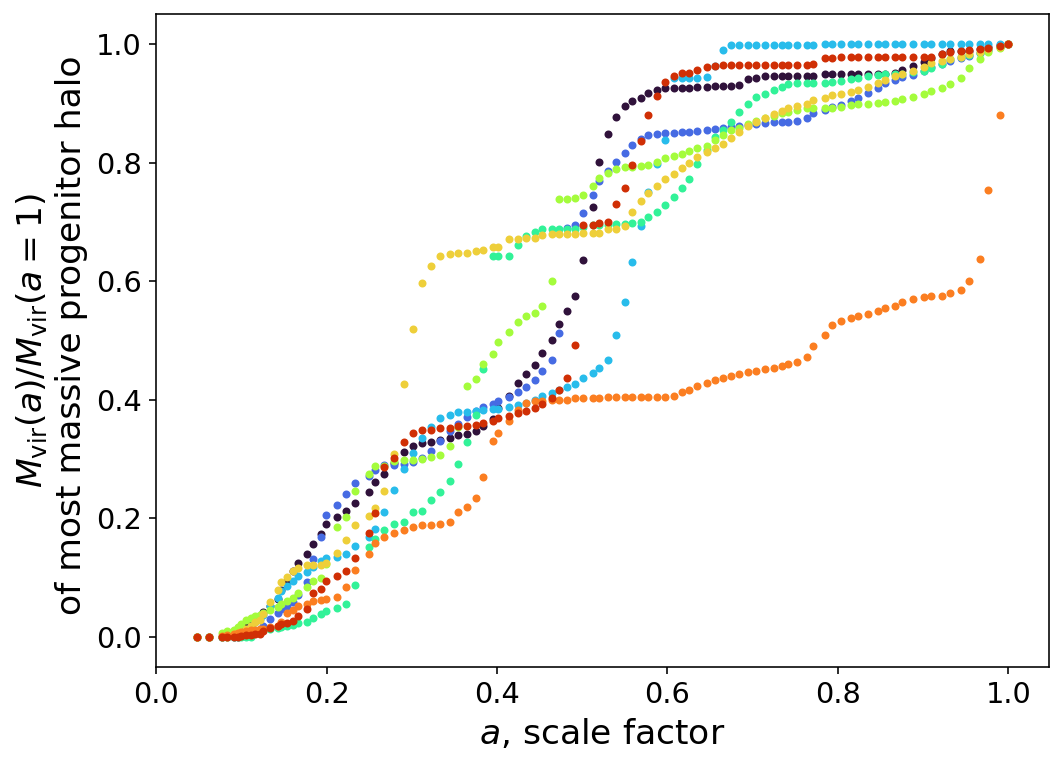

In [22]:
%matplotlib inline
plt.figure(figsize=(8,6))

locs_norm = matplotlib.colors.Normalize(vmin=0, vmax=n_ex)
cmap = matplotlib.cm.get_cmap('turbo')
colors = [cmap(locs_norm(i)) for i in range(n_ex)]

for i, i_rand in enumerate(rand_idxs):
    halo = sim_reader.dark_halo_arr[i_rand]
    plt.plot(avals, y[i_rand], marker='o', markersize=3, ls='None', color=colors[i])

plt.xlabel(r'$a$, scale factor')
plt.ylabel(r'$M_\mathrm{vir}(a)$/$M_\mathrm{vir}(a=1)$'+'\n of most massive progenitor halo')

Text(0, 0.5, '$M_\\mathrm{vir}(a)$/$M_\\mathrm{vir}(a=1)$ of most massive progenitor halo')

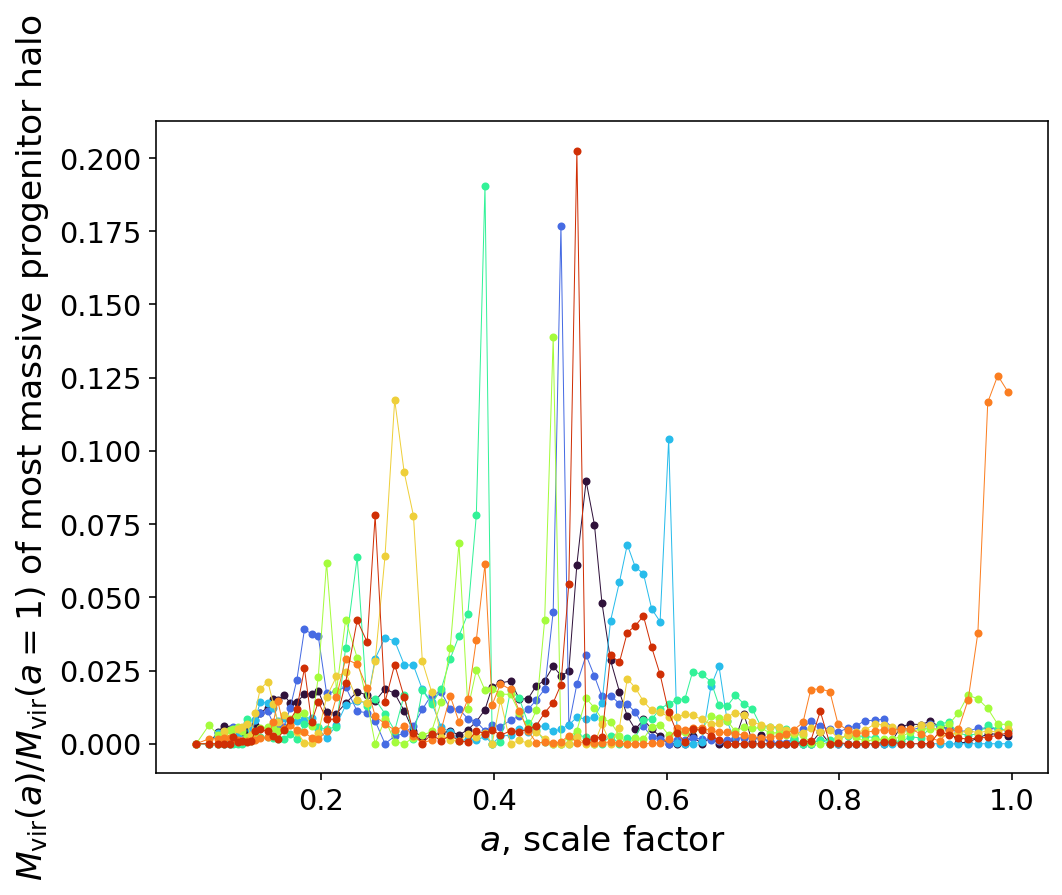

In [73]:
%matplotlib inline
plt.figure(figsize=(8,6))

locs_norm = matplotlib.colors.Normalize(vmin=0, vmax=n_ex)
cmap = matplotlib.cm.get_cmap('turbo')
colors = [cmap(locs_norm(i)) for i in range(n_ex)]

for i, i_rand in enumerate(rand_idxs):
    halo = sim_reader.dark_halo_arr[i_rand]

    yi = y[i_rand]
    diff = -1*(yi[1:] - yi[:-1])
    avals_avg = 0.5*(avals[1:] + avals[:-1])
    plt.plot(avals_avg, diff, marker='o', markersize=3, ls='-', lw=0.5, color=colors[i])

plt.xlabel(r'$a$, scale factor')
plt.ylabel(r'$M_\mathrm{vir}(a)$/$M_\mathrm{vir}(a=1)$ of most massive progenitor halo')

In [23]:
max_epochs = 1000
lr = 0.001
hidden_size = 128
feature_mode = 'scalars'
fit_tag = f'_{y_label_name}_nn_{feature_mode}_epochs{max_epochs}_lr{lr}_hs{hidden_size}'
print(fit_tag)
fn_model = f'../models/models_{sim_name}/model_{sim_name}{halo_tag}{geo_tag}{scalar_tag}{fit_tag}.pt'

_Mofa_nn_scalars_epochs1000_lr0.001_hs128


In [24]:
nnfitter = NNFitter()
nnfitter.load_model(fn_model)

15137.043384354762


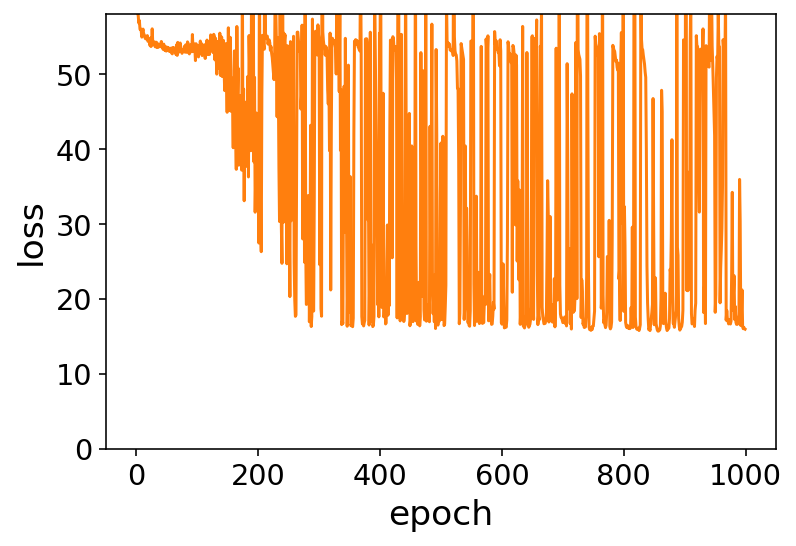

In [25]:
plt.plot(nnfitter.loss_valid)
plt.plot(nnfitter.loss_train)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.ylim(0, nnfitter.loss_train[2])
print(np.min(nnfitter.loss_valid))

15137.043384354762


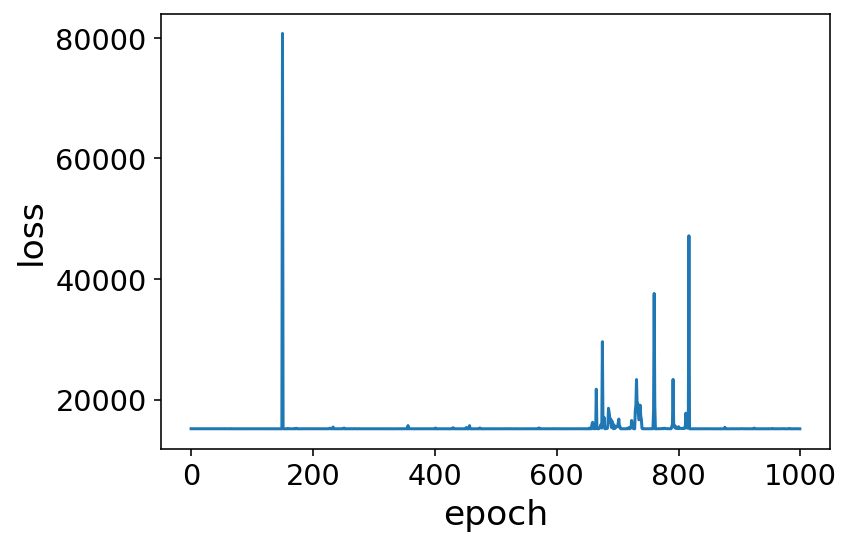

In [26]:
plt.plot(nnfitter.loss_valid)
#plt.plot(nnfitter.loss_train)
plt.xlabel('epoch')
plt.ylabel('loss')
#plt.ylim(0, nnfitter.loss_train[2])
print(np.min(nnfitter.loss_valid))

In [27]:
y_pred = nnfitter.predict(x_test, y_test_current, x_extra=x_test_extra)

/state/partition1/job-26857278/ipykernel_3740347/183306302.py:12: RuntimeWarning: divide by zero encountered in true_divide
  errs = (M_pred - M_true)/M_true
/ext3/miniconda3/envs/eqenv/lib/python3.9/site-packages/numpy/lib/function_base.py:4009: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


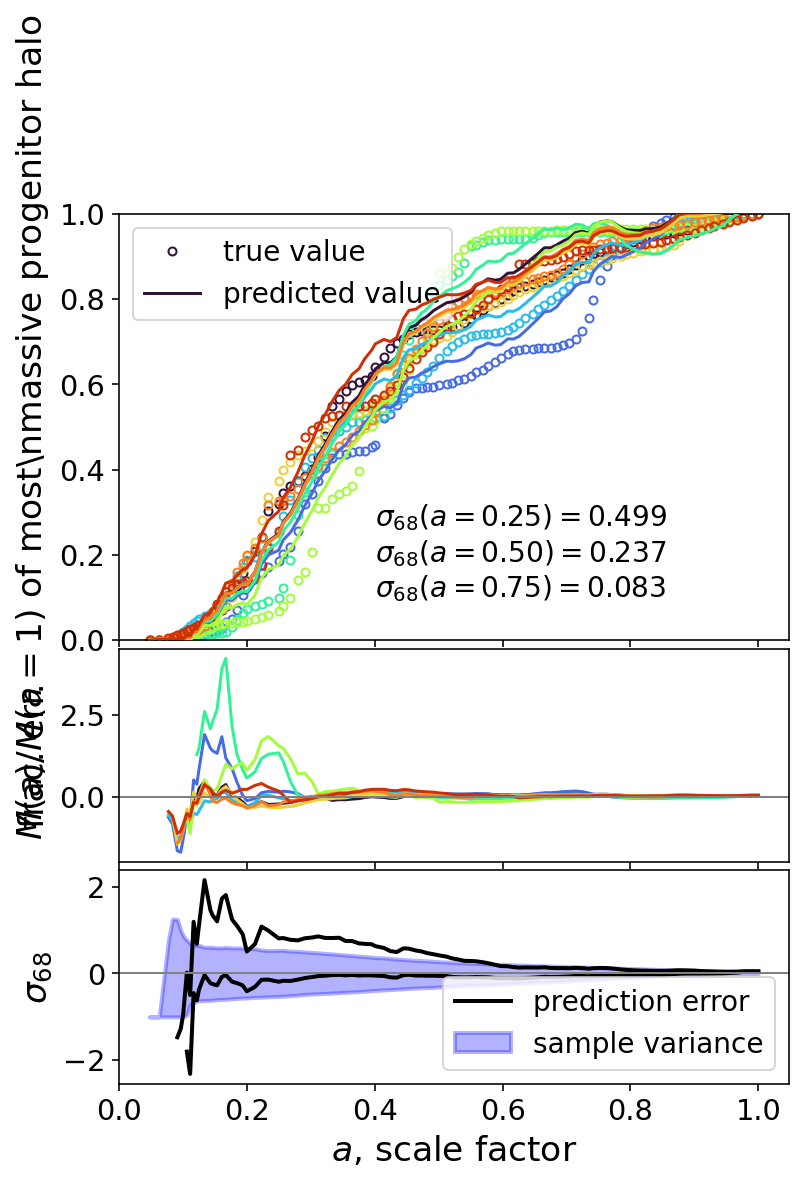

In [28]:
plot_Mofa_accuracy(y_pred, y_test, avals, title='', n_show=8)

# Mstellar features

In [13]:
y_label_name = 'm_stellar'

In [61]:
fit_tag = f'_{y_label_name}_nn_scalars_epochs1000_lr5e-05_hs128'
scalar_tags = ['_x0_v0', '_x2_v2', '_x0_v4', '_x4_v0', '_n0', '_n1', '_n2', '_n01', '']
scalar_label_dict = {'_x0_v0': 'scalars $x \leq 0$, $v \leq 0$',
                     '_x2_v2': r'scalars $x \leq 2$, $v \leq 2$',
                     '_x0_v4': r'scalars $x \leq 0$, $v \leq 4$',
                     '_x4_v0': r'scalars $x \leq 4$, $v \leq 0$',
                     '_n0': r'scalars $r<0.375 R_{200}$ bin',
                     '_n1': r'scalars $0.375 R_{200}<r<R_{200}$ bin',
                     '_n2': r'scalars $r>R_{200}$ bin',
                     '_n01': r'scalars $r<R_{200}$ two bins',
                     '': 'scalars $x \leq 4$, $v \leq 4$',
                    }

In [46]:
y = utils.get_y_vals(y_label_name, sim_reader)
y_test = y[idx_test]

In [47]:
sfeats = []
for i, scalar_tag in enumerate(scalar_tags):
    print(scalar_tag)
    fn_scalar_config = f'../configs/scalar_{sim_name}{halo_tag}{geo_tag}{scalar_tag}.yaml'
    with open(fn_scalar_config, 'r') as file:
        scalar_params = yaml.safe_load(file)
    scp = scalar_params['scalar']
    scalar_featurizer = ScalarFeaturizer(geo_featurizer.geo_feature_arr,
                            n_groups_rebin=scp['n_groups_rebin'], 
                            transform_pseudotensors=scp['transform_pseudotensors'], 
                            mrv_for_rescaling=mrv_for_rescaling)
    scalar_featurizer.load_features(scp['fn_scalar_features'])
    sfeats.append(scalar_featurizer.scalar_features)

_x0_v0
Rebinning geometric features
Transforming pseudotensors
Rescaling geometric features
_x2_v2
Rebinning geometric features
Transforming pseudotensors
Rescaling geometric features
_x0_v4
Rebinning geometric features
Transforming pseudotensors
Rescaling geometric features
_x4_v0
Rebinning geometric features
Transforming pseudotensors
Rescaling geometric features
_n0
Rebinning geometric features
Transforming pseudotensors
Rescaling geometric features
_n1
Rebinning geometric features
Transforming pseudotensors
Rescaling geometric features
_n2
Rebinning geometric features
Transforming pseudotensors
Rescaling geometric features
_n01
Rebinning geometric features
Transforming pseudotensors
Rescaling geometric features

Rebinning geometric features
Transforming pseudotensors
Rescaling geometric features


In [49]:
errors = []
for i, scalar_tag in enumerate(scalar_tags):
    fn_model = f'../models/models_{sim_name}/model_{sim_name}{halo_tag}{geo_tag}{scalar_tag}{fit_tag}.pt'
    nnfitter = NNFitter()
    nnfitter.load_model(fn_model)
    x_test = sfeats[i][idx_test]
    y_pred = nnfitter.predict(x_test, y_current=y_test_current, x_extra=x_test_extra)
    y_test_mult = y_test + log_mass_shift
    y_pred_mult = y_pred + log_mass_shift
    error_nn, _ = utils.compute_error(y_test_mult, y_pred_mult, test_error_type='percentile')
    errors.append(error_nn)

[0 1 2 3 4 5 6 7 8]


Text(0.5, 1.0, 'log($m_\\mathrm{stellar} \\: [h^{-1} \\, M_\\odot]$)')

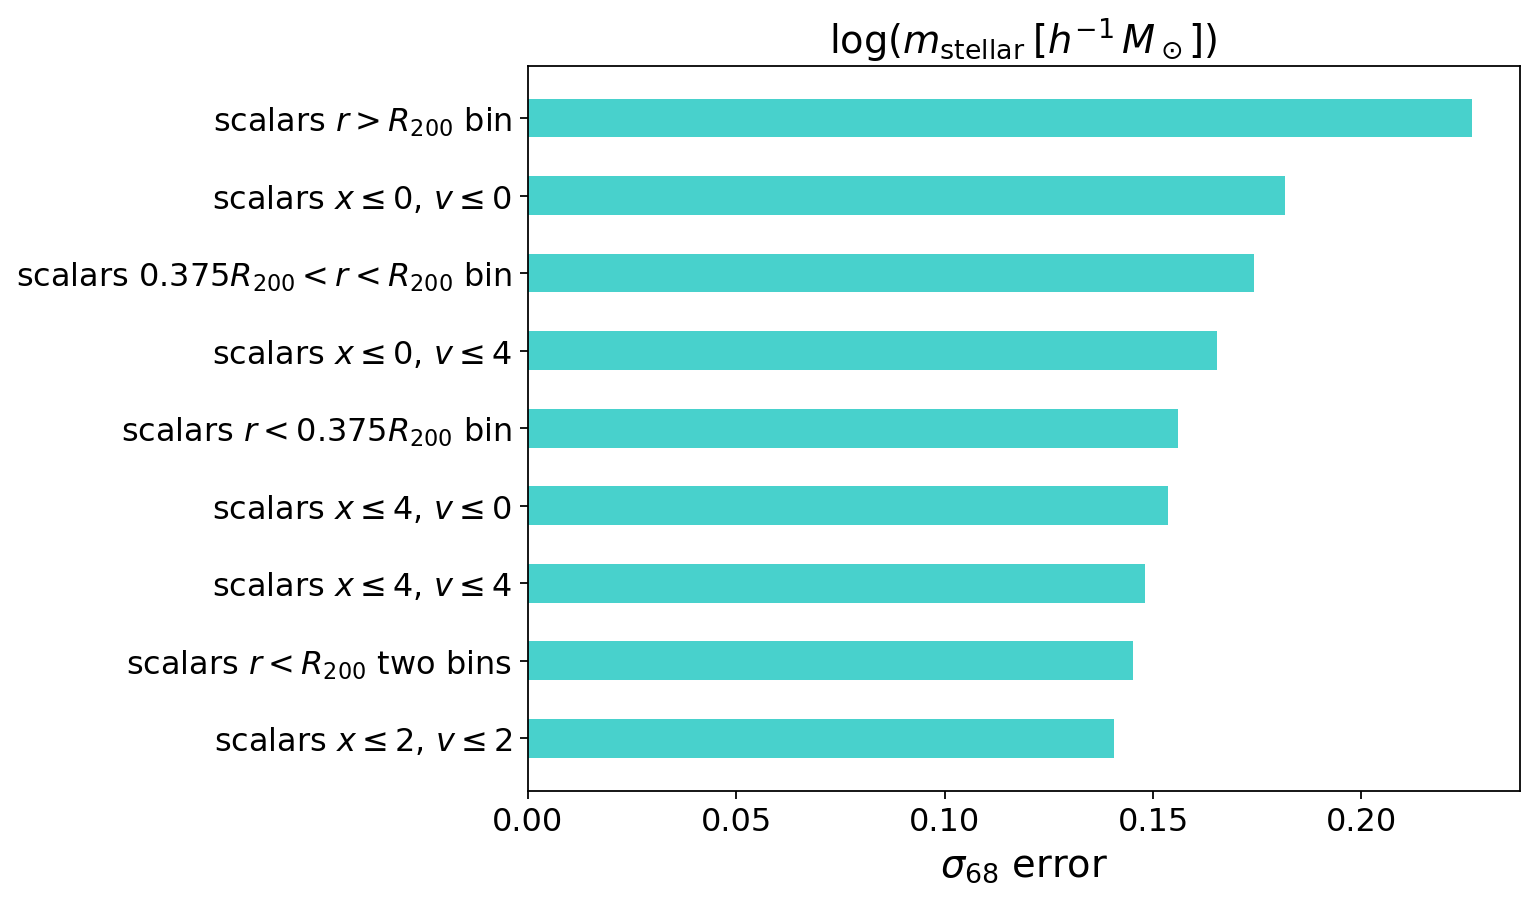

In [64]:
plt.figure(figsize=(8,6))
ax = plt.gca()
scalar_labels = np.array([scalar_label_dict[s] for s in scalar_tags])
y_pos = np.array(list(range(len(scalar_tags))))
print(y_pos)
errors = np.array(errors)
i_sort = np.argsort(errors)
ax.barh(y_pos, errors[i_sort], align='center', height=0.5, color='mediumturquoise')
ax.set_yticks(y_pos, labels=scalar_labels[i_sort])
ax.set_xlabel(r'$\sigma_{68}$ error')

plt.title(utils.label_dict[y_label_name])

# mstellar figure

In [72]:
x_label_name = 'm_200m'
y_label_name = 'm_stellar'
fit_tag = f'_{y_label_name}_nn_scalars_epochs1000_lr5e-05_hs128'
fn_model = f'../models/models_{sim_name}/model_{sim_name}{halo_tag}{geo_tag}{scalar_tag}{fit_tag}.pt'

y = utils.get_y_vals(y_label_name, sim_reader)
y_test = y[idx_test]
y_train = y[idx_train]

nnfitter = NNFitter()
nnfitter.load_model(fn_model)

import torch
model_checkpoint = torch.load(fn_model)

y_pred = nnfitter.predict(x_test, y_current=y_test_current, x_extra=x_test_extra)

y_test_mult = y_test + log_mass_shift
y_pred_mult = y_pred + log_mass_shift
error_nn, _ = utils.compute_error(y_test_mult, y_pred_mult, test_error_type='percentile')
error_str = fr"$\sigma_{{68}}$: {error_nn:.3f} dex"

x_property = log_m_200m[idx_test] + log_mass_shift

In [230]:
def plot_pred_vs_true_hist(ax, y_label_name, y_true, y_pred, cmap,
                      text_results='', title=None, save_fn=None,
                      colorbar_fig=None,
                      colorbar_label=''):
    
    ax.set_title(title)

    y_label = utils.label_dict[y_label_name] if y_label_name in utils.label_dict else y_label_name

    #ticks = np.arange(5, 25, 5)
        
    y_lim = utils.lim_dict[y_label_name]
    bins = np.linspace(y_lim[0], y_lim[1], 100)
    

    h = ax.hist2d(y_true, y_pred, bins=bins, cmap=cmap, cmin=1)
    
    #cbar.ax.set_yticklabels(ticks)
    
    true_line = np.linspace(*y_lim)
    ax.plot(true_line, true_line, color='grey', zorder=0)

    # labels & adjustments
    ax.set_xlabel(y_label + ', true')
    ax.set_ylabel(y_label + ', predicted')

    ax.set_aspect('equal')
    
    ax.set_xlim(y_lim)
    ax.set_ylim(y_lim)

    ax.text(0.1, 0.9, text_results, 
             transform=ax.transAxes, verticalalignment='top', fontsize=22)
    
    if colorbar_fig is not None:
        #ticks = np.arange(5, 25, 5)
        cbar = colorbar_fig.colorbar(h[3], ax=ax, label='number of test objects')#, ticks=ticks)
        #cbar.ax.set_yticklabels(ticks)
        
    return h

In [193]:
def plot_residual_vs_property_hist(ax, x_label_name, y_label_name, x_property, y_true, y_pred,
                               cmap, text_results='',
                               x_lim=(10.5, 14)):

    y_label = utils.label_dict[y_label_name]

    ticks = np.arange(5, 25, 5)
    
    x_lim = utils.lim_dict[x_label_name]    
    bins_x = np.linspace(x_lim[0], x_lim[1], 100)
    bins_y = np.linspace(-1, 1, 100)

    ax.hist2d(x_property, y_pred-y_true, bins=[bins_x, bins_y], 
              cmap=cmap, cmin=1)
    
    # labels & adjustments
    x_label = utils.label_dict[x_label_name]
    y_label = utils.label_dict[y_label_name]
    ax.set_xlabel(x_label)
    ax.set_ylabel(r'$\Delta$ ' + y_label)
    
    ax.set_xlim(x_lim)

    ax.axhline(0, color='grey')
    ax.text(0.1, 0.9, text_results, 
             transform=ax.transAxes, verticalalignment='top', fontsize=22)

In [157]:
def plot_pred_vs_property_hist(ax, x_label_name, y_label_name, x_property, y_pred,
                               cmap, text_results=''):

    y_label = utils.label_dict[y_label_name]

    ticks = np.arange(5, 25, 5)
    
    x_lim = utils.lim_dict[x_label_name]
    y_lim = utils.lim_dict[y_label_name]
    
    bins_x = np.linspace(x_lim[0], x_lim[1], 100)
    bins_y = np.linspace(y_lim[0], y_lim[1], 100)

    ax.hist2d(x_property, y_pred, bins=[bins_x, bins_y], cmap=cmap, cmin=1)

    # labels & adjustments
    x_label = utils.label_dict[x_label_name]
    y_label = utils.label_dict[y_label_name]
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label + ', predicted')
    
    ax.set_xlim(x_lim)
    ax.set_ylim(y_lim)

    ax.text(0.1, 0.9, text_results, 
             transform=ax.transAxes, verticalalignment='top', fontsize=22)

In [122]:
def plot_multi_panel_pred(x_label_name, y_label_name, x_property, y_true, y_pred,
                      text_results='', title=None, save_fn=None,
                      x_lim=(7,12), y_lim=(7,12), colors_test=None,
                      colorbar_label=''):
    fig, axarr = plt.subplots(nrows=2, ncols=2, figsize=(12,12),
                              gridspec_kw={'height_ratios': [1, 1], 'width_ratios': [10, 9]})
    
    inferno_r = matplotlib.cm.inferno_r
    cmap = utils.shiftedColorMap(inferno_r, start=0.1, stop=1.0)
    
    plot_pred_vs_property_hist(axarr[0,0], x_label_name, y_label_name, x_property, y_pred, cmap)
    
    h = plot_pred_vs_true_hist(axarr[0,1], y_label_name, y_true, y_pred, cmap, text_results=text_results,
                               x_lim=x_lim,  y_lim=x_lim)
    
    plot_residual_vs_property_hist(axarr[1,0], x_label_name, y_label_name, x_property, y_true, y_pred, cmap)

    fig.delaxes(axarr[1,1])
    
    ticks = np.arange(5, 25, 5)
    cax = fig.add_axes([0.93, 0.54, 0.02, 0.33])
    cbar = plt.colorbar(h[3], cax=cax, label='number of test objects', ticks=ticks)
    cbar.ax.set_yticklabels(ticks)

/home/ksf293/equivariant-cosmology/notebooks/../code/utils.py:322: UserWarning: Trying to register the cmap 'shiftedcmap' which already exists.
  plt.register_cmap(cmap=newcmap)


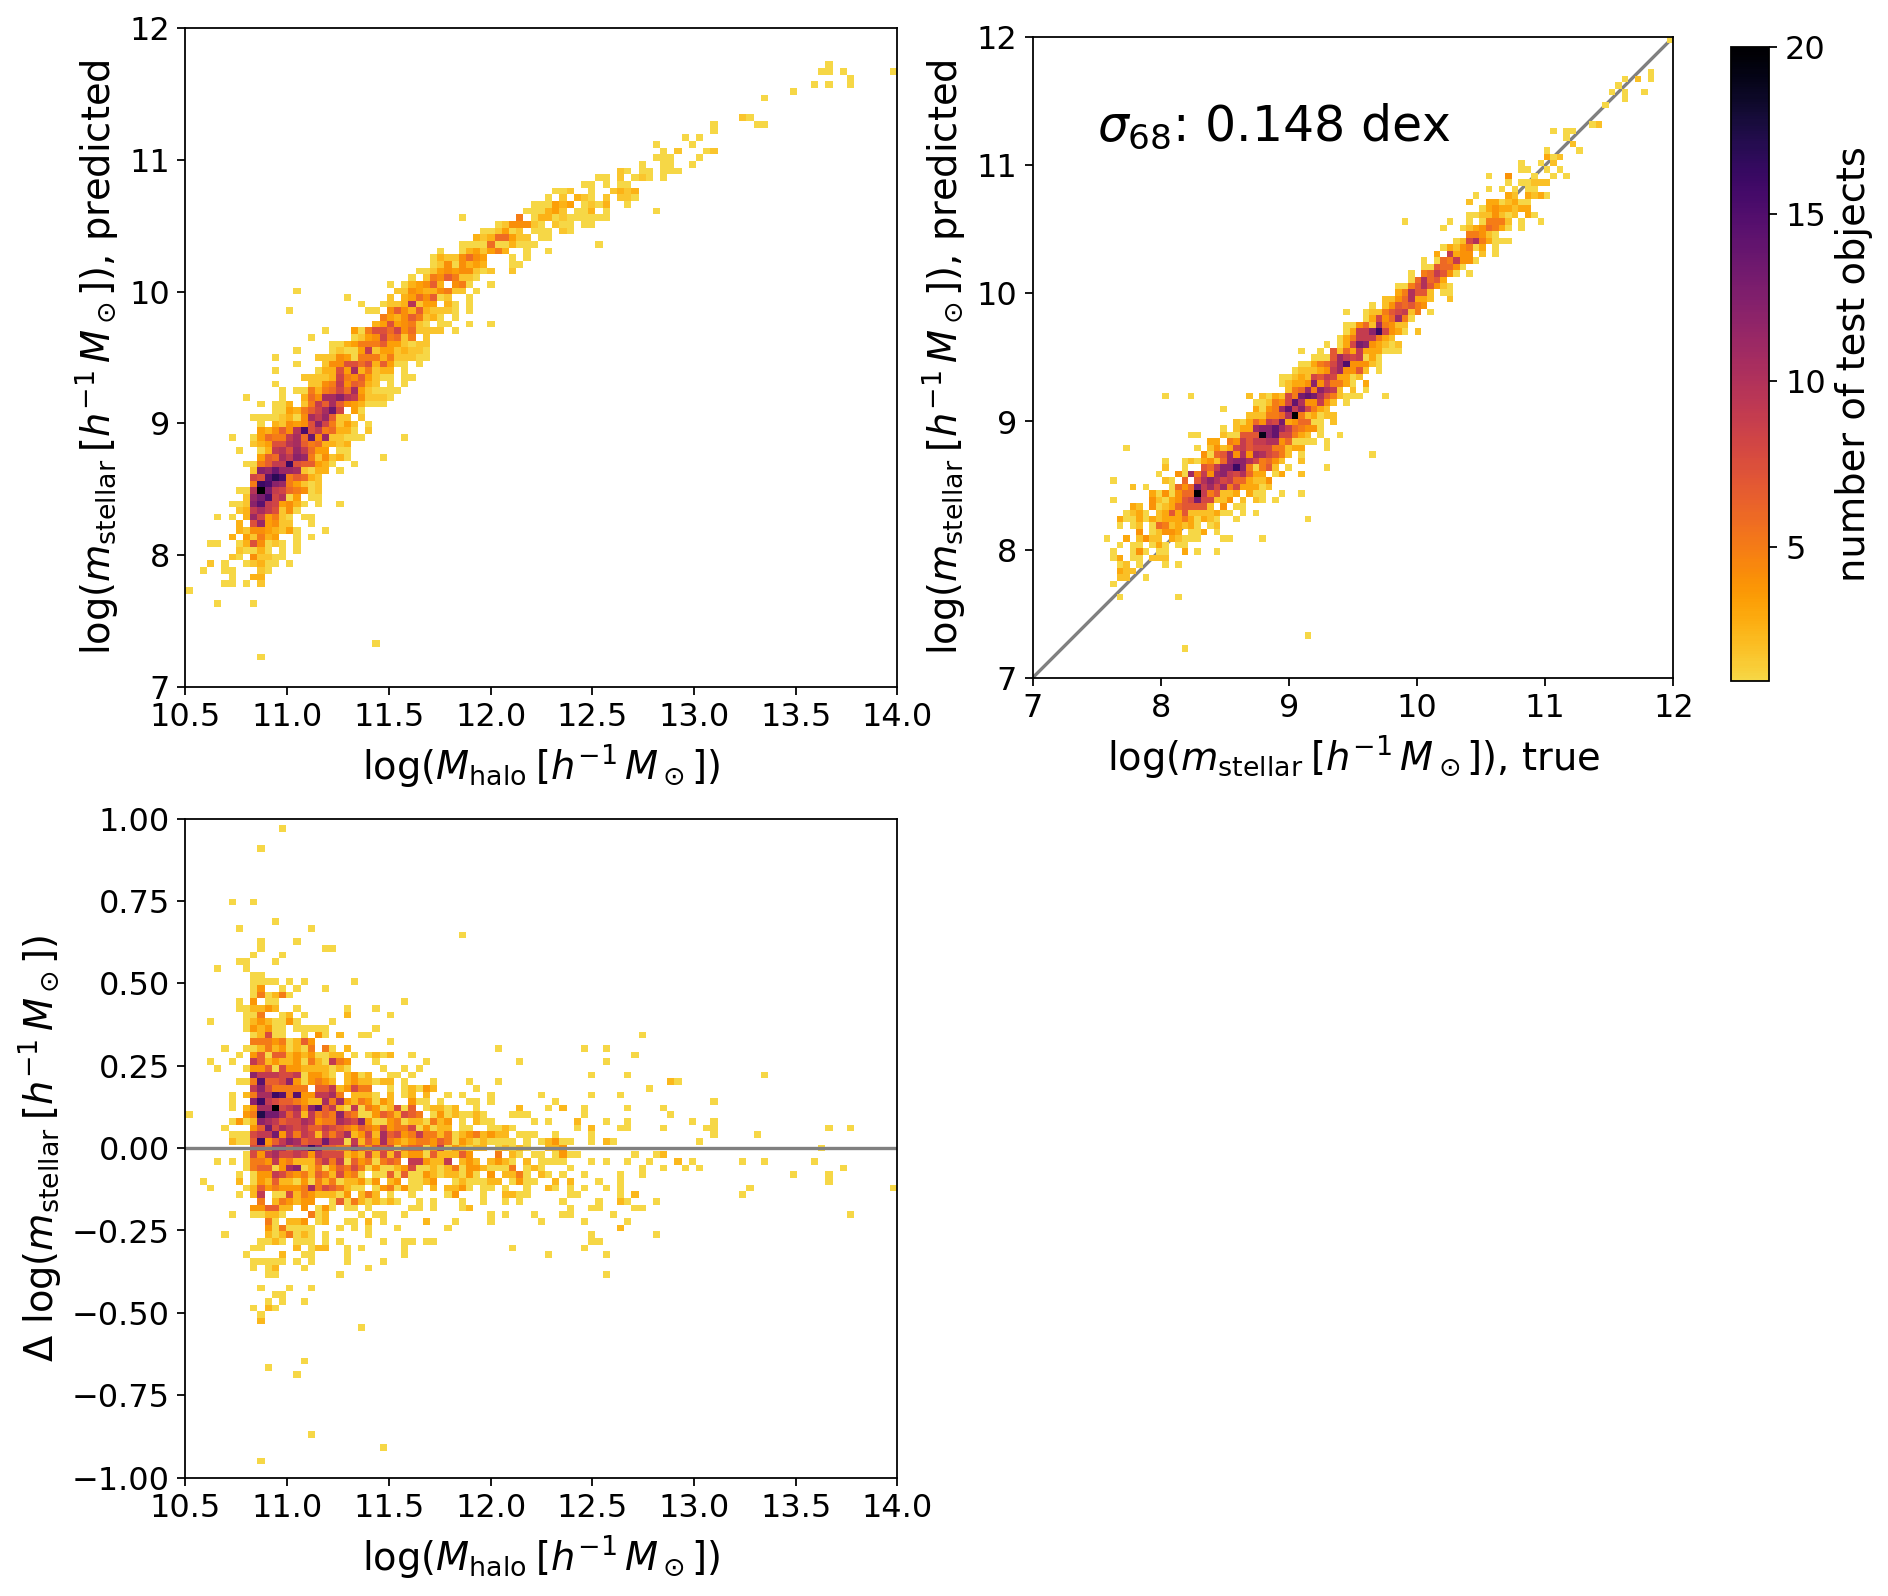

In [125]:
plot_multi_panel_pred(x_label_name, y_label_name, x_property, y_test_mult, y_pred_mult, text_results=error_str,
                               x_lim=(7,12),  y_lim=(7,12))

## multi feature

In [228]:
x_label_name = 'm_200m'
y_label_name = 'm_stellar'

feature_names = ['mrv', 'catalog', 'geos', 'scalars']
fit_tags = [f'_{y_label_name}_nn_{feature_name}_epochs1000_lr5e-05_hs128' for feature_name in feature_names]

y_pred_arr = []
text_results_arr = []
    
y = utils.get_y_vals(y_label_name, sim_reader)
y_test = y[idx_test] 
y_test_mult = y_test + log_mass_shift

for i, fit_tag in enumerate(fit_tags):
    print(fit_tag)
    
    x = x_dict[feature_names[i]]
    x_extra = x_extra_dict[feature_names[i]]
    if x is not None:
        x_test = x[idx_test]
    else:
        x_test = None
    if x_extra is not None:
        x_test_extra = x_extra[idx_test]
    else:
        x_test_extra = None
        
    fn_model = f'../models/models_{sim_name}/model_{sim_name}{halo_tag}{geo_tag}{scalar_tag}{fit_tag}.pt'

    nnfitter = NNFitter()
    nnfitter.load_model(fn_model)

    model_checkpoint = torch.load(fn_model)

    y_pred = nnfitter.predict(x_test, y_current=y_test_current, x_extra=x_test_extra)

    y_pred_mult = y_pred + log_mass_shift
    
    error_nn, _ = utils.compute_error(y_test_mult, y_pred_mult, test_error_type='percentile')
    error_str = fr"$\sigma_{{68}}$: {error_nn:.3f} dex"

    
    y_pred_arr.append(y_pred_mult)
    text_results_arr.append(error_str)

_m_stellar_nn_mrv_epochs1000_lr5e-05_hs128
_m_stellar_nn_catalog_epochs1000_lr5e-05_hs128
_m_stellar_nn_geos_epochs1000_lr5e-05_hs128
_m_stellar_nn_scalars_epochs1000_lr5e-05_hs128


In [236]:
def plot_multi_panel_feature(y_label_name, y_true, y_pred_arr,
                      nrows=2, ncols=2, 
                      text_results_arr=[], titles=None, save_fn=None,
                      colorbar_label='', colorbar_fig=None):
    
    fig, axarr = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12,12))
    plt.subplots_adjust(hspace=0.3, wspace=0.3)
    
    inferno_r = matplotlib.cm.inferno_r
    cmap = utils.shiftedColorMap(inferno_r, start=0.1, stop=1.0)
    
    i = 0
    for nr in range(nrows):
        for nc in range(ncols):

            h = plot_pred_vs_true_hist(axarr[nr,nc], y_label_name, y_true, y_pred_arr[i], cmap, 
                                       text_results=text_results_arr[i], colorbar_fig=colorbar_fig,
                                       title=titles[i])
            i += 1
    
#     ticks = np.arange(5, 25, 5)
#     cax = fig.add_axes([0.93, 0.54, 0.02, 0.33])
#     cbar = plt.colorbar(h[3], cax=cax, label='number of test objects', ticks=ticks)
#     cbar.ax.set_yticklabels(ticks)

/home/ksf293/equivariant-cosmology/notebooks/../code/utils.py:327: UserWarning: Trying to register the cmap 'shiftedcmap' which already exists.
  plt.register_cmap(cmap=newcmap)


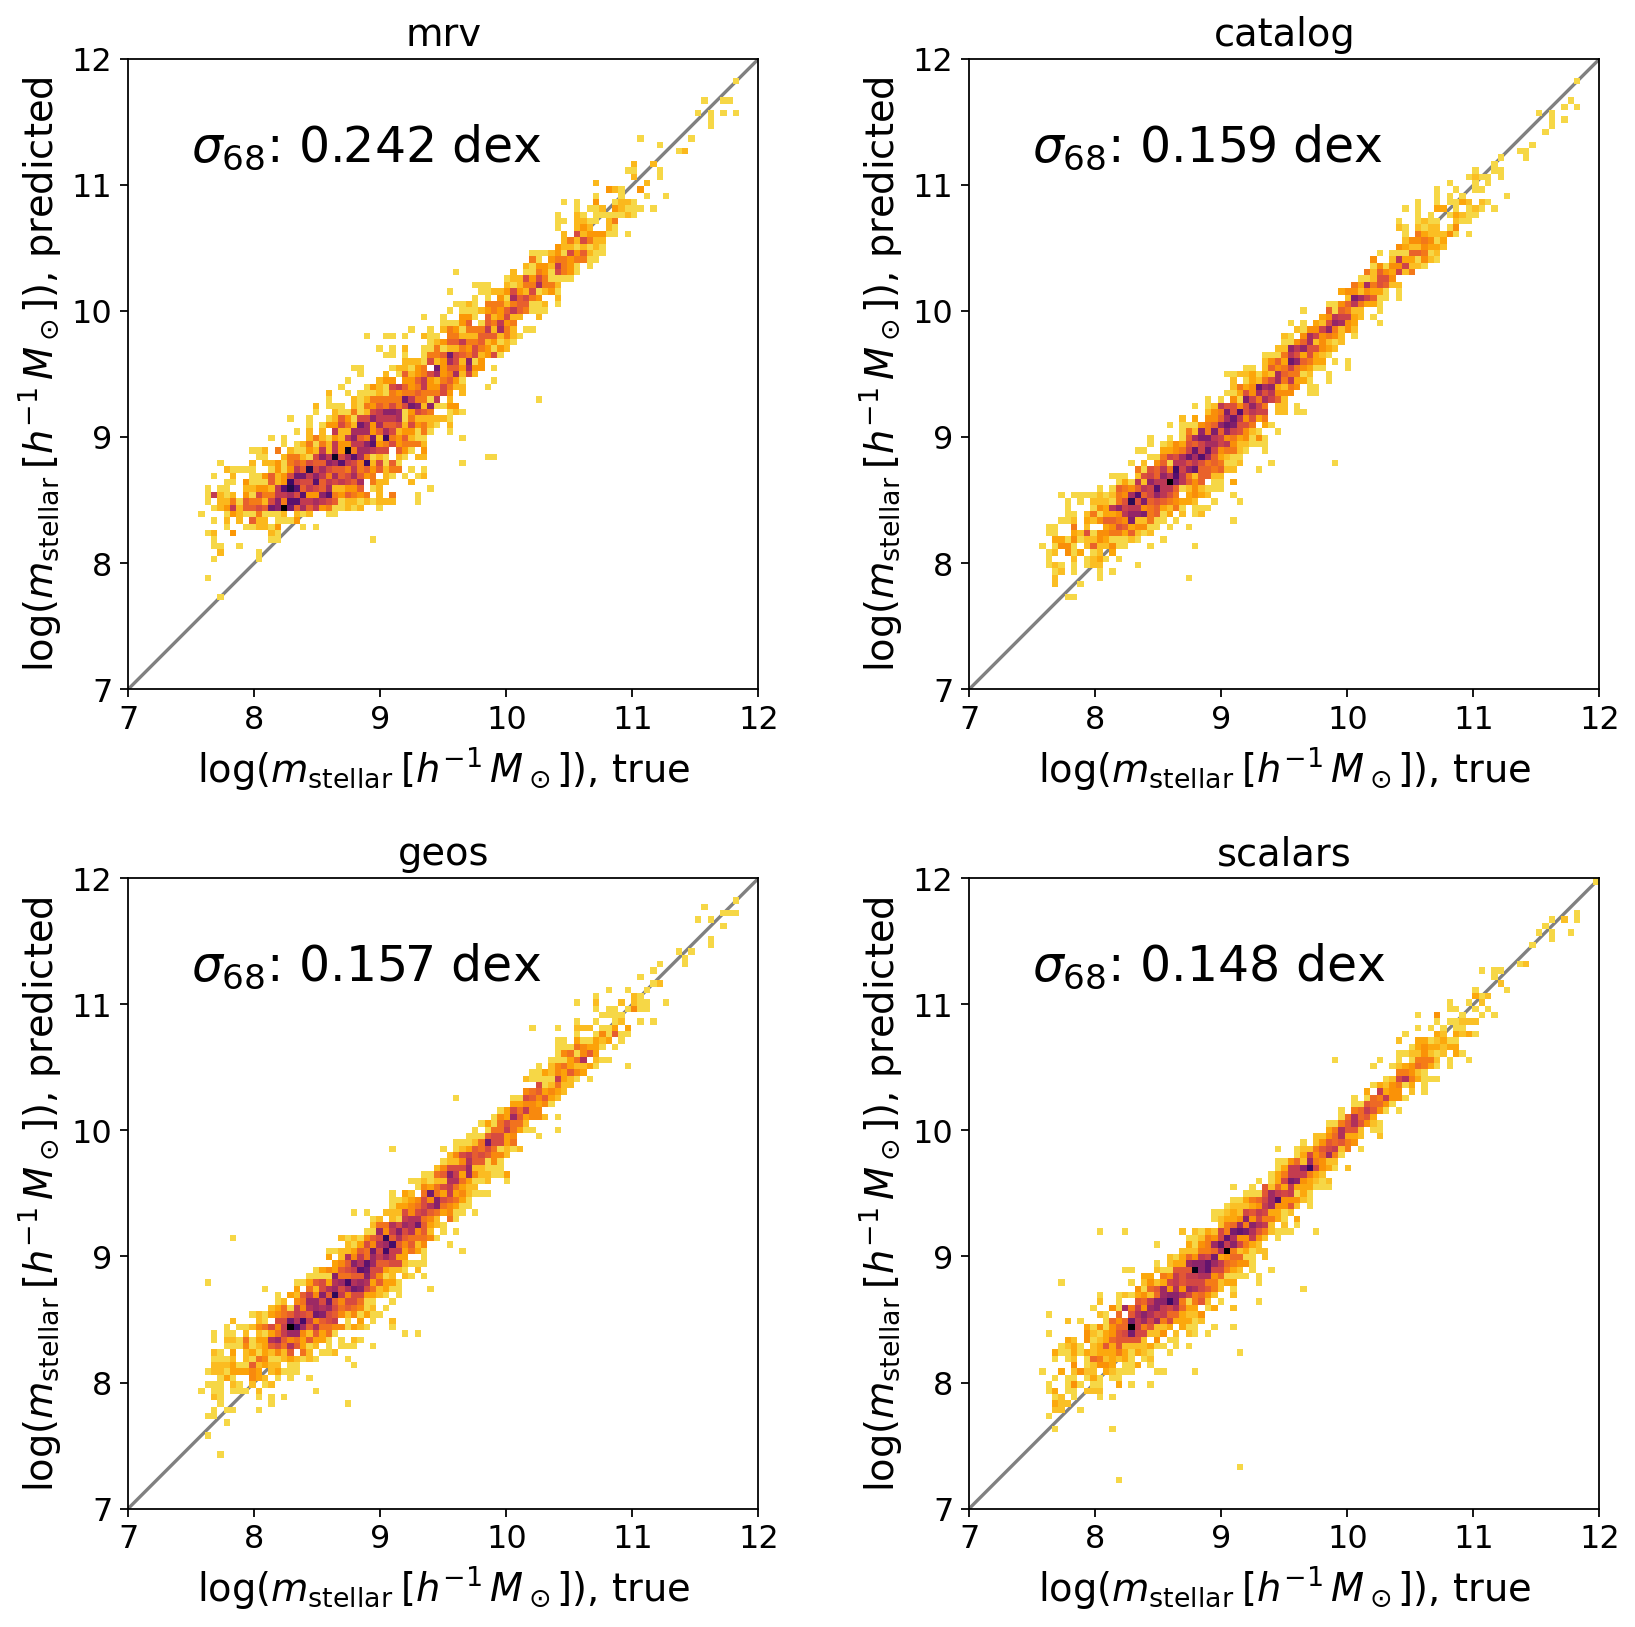

In [237]:
plot_multi_panel_feature(y_label_name, y_test_mult, y_pred_arr, text_results_arr=text_results_arr,
                        titles=feature_names)

## multi property

In [204]:
def plot_multi_panel_gal_props(x_label_name, y_label_name_arr, x_property, y_true_arr, y_pred_arr,
                      text_results_arr=[], title=None, save_fn=None,
                      colorbar_label=''):
    
    nprops = len(y_label_name_arr)
    fig, axarr = plt.subplots(nrows=nprops, ncols=2, figsize=(nprops*6, 10),
                              gridspec_kw={'width_ratios': [1, 1.1]})
    plt.subplots_adjust(hspace=0.2, wspace=0.3)
    
    inferno_r = matplotlib.cm.inferno_r
    cmap = utils.shiftedColorMap(inferno_r, start=0.1, stop=1.0)
    
    for i in range(nprops):
        plot_pred_vs_property_hist(axarr[i,0], x_label_name, y_label_name_arr[i], x_property, y_pred_arr[i], 
                                   cmap)

        h = plot_pred_vs_true_hist(axarr[i,1], y_label_name_arr[i], y_true_arr[i], y_pred_arr[i], cmap, 
                                   text_results=text_results_arr[i], colorbar_fig=fig)
    
    
#     ticks = np.arange(5, 25, 5)
#     cax = fig.add_axes([0.93, 0.54, 0.02, 0.33])
#     cbar = plt.colorbar(h[3], cax=cax, label='number of test objects', ticks=ticks)
#     cbar.ax.set_yticklabels(ticks)

In [187]:
x_label_name = 'm_200m'
y_label_name_arr = ['ssfr1', 'r_stellar']

y_true_arr = []
y_pred_arr = []
text_results_arr = []
    
for y_label_name in y_label_name_arr:
    fit_tag = f'_{y_label_name}_nn'
    fn_model = f'../models/models_{sim_name}/model_{sim_name}{halo_tag}{geo_tag}{scalar_tag}{fit_tag}.pt'

    y = utils.get_y_vals(y_label_name, sim_reader)
    y_test = y[idx_test]

    nnfitter = NNFitter()
    nnfitter.load_model(fn_model)

    model_checkpoint = torch.load(fn_model)

    y_pred = nnfitter.predict(x_test, y_current=y_test_current, x_extra=x_test_extra)

    y_test_mult = y_test #+ log_mass_shift
    y_pred_mult = y_pred #+ log_mass_shift
    error_nn, _ = utils.compute_error(y_test_mult, y_pred_mult, test_error_type='percentile')
    error_str = fr"$\sigma_{{68}}$: {error_nn:.3f} dex"
    
    print(np.min(y_test_mult), np.max(y_test_mult))
    print(np.min(y_pred_mult), np.max(y_pred_mult))
    y_true_arr.append(y_test_mult)
    y_pred_arr.append(y_pred_mult)
    text_results_arr.append(error_str)
    
x_property = log_m_200m[idx_test] + log_mass_shift

-14.179892539978027 -9.219365923642847
-12.769299586598414 -8.538964584036249
-0.437626 1.7136068
-0.6046230368907354 1.6088802208869815


/home/ksf293/equivariant-cosmology/notebooks/../code/utils.py:327: UserWarning: Trying to register the cmap 'shiftedcmap' which already exists.
  # little h via https://www.tng-project.org/data/downloads/TNG100-1/


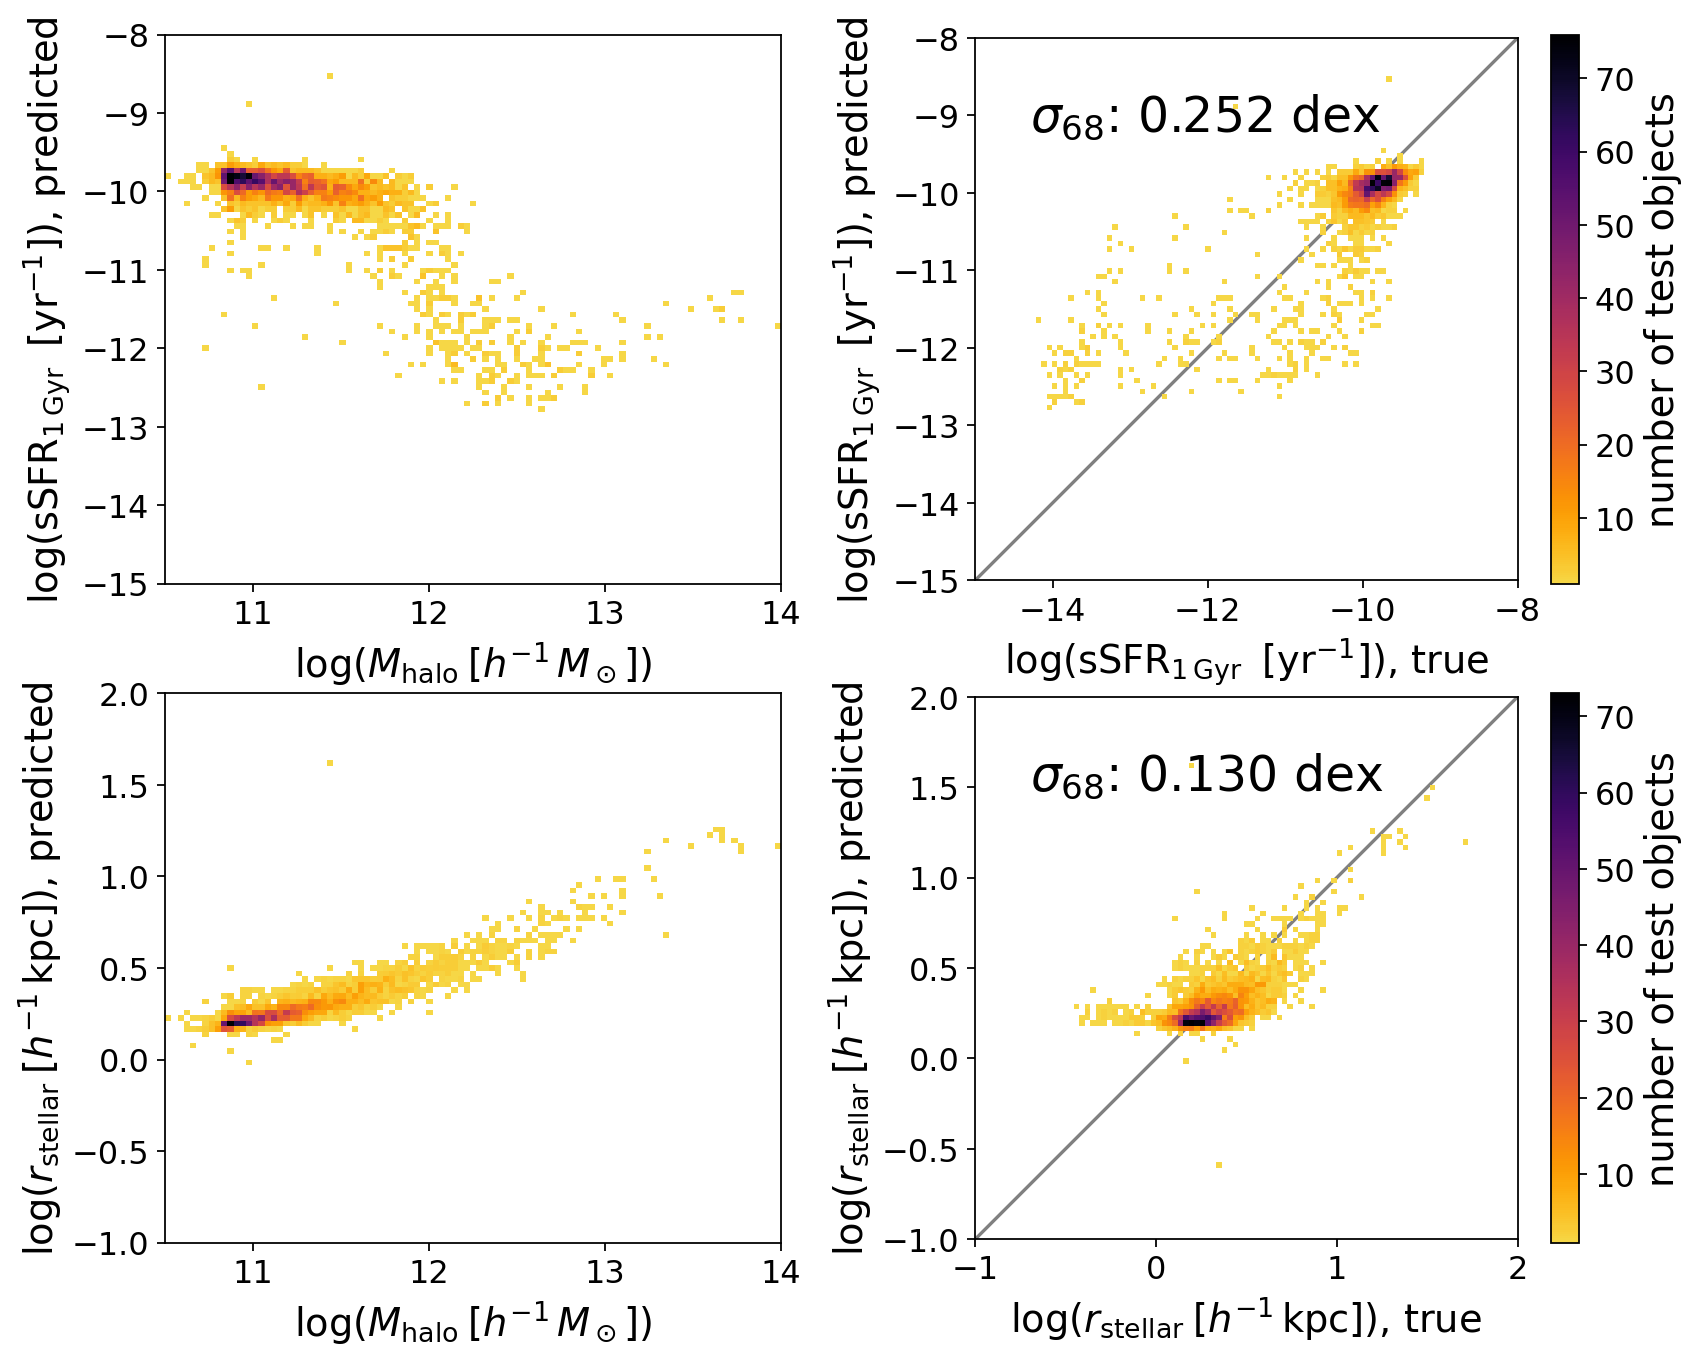

In [205]:
plot_multi_panel_gal_props(x_label_name, y_label_name_arr, x_property, y_true_arr, y_pred_arr,
                      text_results_arr=text_results_arr)